In [64]:
import time
import numpy as np
import yaml
import sys
import awkward as ak
import uproot as ur
from data import particle_data_visualize_plot_utils as pu
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
from numpy import genfromtxt

sys.path.append('/home/jbohm/start_tf/LCStudies')

LOG_ENERGY_MEAN = -1 # unrounded mean is ~ -0.93
LOG_MEAN_TRACK_MOMETUM = 2

In [65]:
# helper functions
def spherical_to_cartesian(rs, phis, thetas):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.cos(phis[i]))
        y.append(r*np.sin(phis[i]))
        z.append( r/np.tan(thetas[i]))

    return np.array(x), np.array(y), np.array(z)

def flatten_clus_in_events(events):
    return [[cell for clus in event for cell in clus] for event in events]

def flatten_one_layer(data):
    return [data_layer2 for data_layer1 in data for data_layer2 in data_layer1]

def flatten_layers(data, num_layers=1):
    for i in range(num_layers):
        data = flatten_one_layer(data)
    return data

def plot_truth_E_comparison(truth_E_1, truth_E_2, title, xlabel, ylabel, lim=None):
    fig = plt.figure(figsize=(6.2,6.2))
    fig.patch.set_facecolor('white')
    plt.scatter(truth_E_1, truth_E_2, color="mediumorchid")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.arange(np.max(truth_E_1)), np.arange(np.max(truth_E_1)), color="black")
    plt.xlim(lim)
    plt.ylim(lim)
    plt.show()



In [139]:
pastel_colors = [
    "#440154FF",
    "#FDE725FF",
    "#74BF43",
    (0.6784, 0.8471, 0.9020),  # Lightblue
    (1.0000, 0.7137, 0.7569),  # Lightpink
    (0.8196, 0.7686, 0.9412),  # Lavender
    
    (0.5647, 0.9333, 0.5647),  # Lightgreen
    (1.0000, 0.9804, 0.8039),  # Lightyellow
    
    (1.0000, 0.6275, 0.4784),  # Lightsalmon
    (0.8471, 0.7490, 0.8471),  # Thistle
    (1.0000, 0.8941, 0.8824),  # Mistyrose
    (1.0000, 0.8549, 0.7255)   # Peachpuff
]


def plot_proccessed_cells_in_line(x, y, z, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, event_idx=None, vmin=None, vmax=None, same_axis=True, add_track=False, add_topo=False):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_size_inches(5*len(cell_data), 5)
    for i, cell_data_i in enumerate(cell_data):
        ax = fig.add_subplot(1, len(cell_data), i + 1, projection='3d')
        x_i = x[i] if len(x) > 1 else x[0]
        y_i = y[i] if len(y) > 1 else y[0]
        z_i = z[i] if len(z) > 1 else z[0]
        xlabel_i = xlabel[i] if len(xlabel) > 1 else xlabel[0]
        ylabel_i = ylabel[i] if len(ylabel) > 1 else ylabel[0]
        zlabel_i = zlabel[i] if len(zlabel) > 1 else zlabel[0]
        title_i = title[i] if len(title) > 1 else title[0]

        if title[i] == "Clustered cells":
            for clus_idx in range(2):#range(0, np.max(processed_event_data["clus_idx"][event_idx]) + 1):
                ax.scatter(processed_event_data["z"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["x"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["y"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], label=["pi class", "pi/pi class"][clus_idx], color=pastel_colors[clus_idx])
            ax.legend()
            
        elif bar_label[i] == "Pi+/- frac class" or bar_label[i] == "Pred EM frac class":
            cut_em_class = np.array(cell_data_i) == 1
            clus_x = np.array(x_i)
            clus_y = np.array(y_i)
            clus_z = np.array(z_i)
            ax.scatter(clus_z[cut_em_class], clus_x[cut_em_class], clus_y[cut_em_class], color="fuchsia")
            ax.scatter(clus_z[~cut_em_class], clus_x[~cut_em_class], clus_y[~cut_em_class], color="cyan")  
        #elif title[i] == "Cluster EM probability":
        #    print("not loaded atm")
        elif title[i] == "Input point data":
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i], zorder=1, norm=mpl.colors.LogNorm())
            #if bar_label[i] != "EM frac class":
            #fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)
        else:
            p = ax.scatter(z_i, x_i, y_i, c=cell_data_i, vmin=vmin[i], vmax=vmax[i], cmap=colour_theme[i], zorder=1)
            #if bar_label[i] != "EM frac class":
            #fig.colorbar(p, label=bar_label[i], fraction=0.025, pad=0.15)
        
        if add_track and (title[i] == "Input point data" or title[i] == "Input point data" or title[i] == "Fraction of cell energy from pi" or title[i] == "Cell truth classes"):
            ax.scatter(processed_event_track_data["z"][event_idx][processed_event_track_data["z"][event_idx] != 0], processed_event_track_data["x"][event_idx][processed_event_track_data["x"][event_idx] != 0], processed_event_track_data["y"][event_idx][processed_event_track_data["y"][event_idx] != 0], color="black")
            ax.plot(processed_event_track_data["z"][event_idx][processed_event_track_data["z"][event_idx] != 0], processed_event_track_data["x"][event_idx][processed_event_track_data["x"][event_idx] != 0], processed_event_track_data["y"][event_idx][processed_event_track_data["y"][event_idx] != 0], color="black")
            ax.set_xlim(np.min(z_i), np.max(z_i))
            ax.set_ylim(np.min(x_i), np.max(x_i))
            ax.set_zlim(np.min(y_i), np.max(y_i))

        if add_topo and title[i] == "Predicted classes (+ clusters)":
            for clus_idx in range(0, np.max(processed_event_data["clus_idx"][event_idx]) + 1):
                ax.scatter(processed_event_data["z"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["x"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], processed_event_data["y"][event_idx][processed_event_data["clus_idx"][event_idx] == clus_idx], marker=",", s=90, alpha=0.2, zorder=-1, label="cluster " + str(clus_idx + 1), color=pastel_colors[clus_idx])
            ax.legend()
        ax.set_xlabel(xlabel_i)
        ax.set_ylabel(ylabel_i)
        ax.set_zlabel(zlabel_i)
        plt.title(title_i)
    plt.show()


# plot 3d event info
def plot_event_3d_info(event_idx, pipm_frac, class_pipm_frac, preds):
    x = processed_event_data["x"][event_idx]
    y = processed_event_data["y"][event_idx] 
    z = processed_event_data["z"][event_idx]
    
    title = ["Sampling layers", "Input point data", "Fraction of cell energy from pi", "Clustered cells", "Cell truth classes", "Cluster EM probability", "Predicted classes", "Predicted classes (+ clusters)"]
    xlabel = ["z"]
    ylabel = ["x"]
    zlabel = ["y"]

    colour_theme = [plt.cm.tab20b, plt.cm.magma, plt.cm.viridis_r, None, plt.cm.viridis_r, plt.cm.viridis_r, plt.cm.viridis_r, plt.cm.viridis_r]
    bar_label = ["Sampling layers", "Cell energy (GeV)", "pi energy frac", "", "Truth Pi0 frac class",  "EM probability", "Predicted classes", "Predicted classes"]
    vmin = [0, None , 0, None, 0, 0, 0, 0]
    vmax = [23, None, 1, None, 1, 1, 1, 1]
    cell_data = [processed_event_data["sampling_layer"][event_idx],  10**(np.array(processed_event_data["cell_E"][event_idx]) + LOG_ENERGY_MEAN), pipm_frac, None, class_pipm_frac, processed_event_data["clus_em_prob"][event_idx], preds, preds]
    #cell_data = [processed_event_data["sampling_layer"][event_idx],  processed_event_data["cell_E"][event_idx], pipm_frac, None, class_pipm_frac, None, preds, preds]
    
    #plot_proccessed_cells_in_line([x], [y], [z], cell_data[:4], title[:4], xlabel, ylabel, zlabel, colour_theme[:4], bar_label[:4], event_idx, vmin[:4], vmax[:4], add_track=True, add_topo=True)
    #plot_proccessed_cells_in_line([x], [y], [z], cell_data[4:], title[4:], xlabel, ylabel, zlabel, colour_theme[4:], bar_label[4:], event_idx, vmin[4:], vmax[4:], add_track=True, add_topo=True)
    for i in range(len(title)):
        plot_proccessed_cells_in_line([x], [y], [z], [cell_data[i]], [title[i]], xlabel, ylabel, zlabel, [colour_theme[i]], [bar_label[i]], event_idx, [vmin[i]], [vmax[i]], add_track=True, add_topo=True)
        

In [67]:
# track metadata
calo_layers = ['EMB1', 'EMB2', 'EMB3', 'EME1', 'EME2', 'EME3', 'HEC0', 'HEC1',
    'HEC2', 'HEC3', 'TileBar0', 'TileBar1', 'TileBar2', 'TileGap1', 'TileGap2',
    'TileGap3', 'TileExt0', 'TileExt1', 'TileExt2']

NUM_TRACK_POINTS = len(calo_layers)

has_fixed_r = {
    'EMB1': True,
    'EMB2': True,
    'EMB3': True,
    'EME1': False,
    'EME2': False,
    'EME3': False,
    'HEC0': False,
    'HEC1': False,
    'HEC2': False,
    'HEC3': False,
    'TileBar0': True,
    'TileBar1': True,
    'TileBar2': True,
    'TileGap1': True,
    'TileGap2': True,
    'TileGap3': True,
    'TileExt0': True,
    'TileExt1': True,
    'TileExt2': True
}

fixed_r = {
    'EMB1': 1532.18,
    'EMB2': 1723.89,
    'EMB3': 1923.02,
    'TileBar0': 2450.00,
    'TileBar1': 2995.00,
    'TileBar2': 3630.00,
    'TileGap1': 3215.00,
    'TileGap2': 3630.00,
    'TileGap3': 2246.50,
    'TileExt0': 2450.00,
    'TileExt1': 2870.00,
    'TileExt2': 3480.00
}

fixed_z = {
    'EME1': 3790.03,
    'EME2': 3983.68,
    'EME3': 4195.84,
    'HEC0': 4461.25,
    'HEC1': 4869.50,
    'HEC2': 5424.50,
    'HEC3': 5905.00,
}

In [68]:
rho_dir = "/fast_scratch_1/jbohm/cell_particle_deposit_learning/rho_processed_test_data/" 
files_name = "rho_full"
save_dir = "/fast_scratch_1/jbohm/train_testing_data/"
len_file = 6000
i_low = 0
i_high = 4
energy_threshold = 0
weight_cells = False
include_tracks = True
left_from_include_tracks = False
add_3_min_dists_and_layer = False
delta_R_cut = 0.5
BATCH_SIZE = 100

In [69]:
rho_files = list(map(lambda i:  files_name + "_len_" + str(len_file) + "_i_" + str(i) + ".npy", np.arange(i_low, i_high + 1)))
# load cell geo tree dict
file = ur.open("/data/atlas/data/rho_delta/rho_small.root")
cell_geo_tree = file["CellGeo"]

node_feature_names = cell_geo_tree.keys()[1:7] # 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi', 'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi'


cell_geo_data = cell_geo_tree.arrays(library='np')
cell_geo_ID = cell_geo_data['cell_geo_ID'][0]
sorter = np.argsort(cell_geo_ID)

# cluster data dict to look up data by feature name
processed_event_data = {}
processed_event_track_data = {}
processed_event_track_flags = []

cell_geo_ID = cell_geo_data['cell_geo_ID'][0]

samples_count = 0
max_cells = 0
num_cells = 0

for feature in [*node_feature_names, 'x', 'y', 'z', 'cell_hitsTruthIndex', 'cell_hitsTruthE', 'frac_pi0_energy', 'class_frac_pi0_energy', 'cell_E', 'cell_E_weight', 'sampling_layer', 'truthPartPt', 'truthPartEta', 'truthPartPhi', 'clus_idx', 'clus_em_prob']:#, 'delta_R']:
    processed_event_data[feature] = []

for feature in ['x', 'y', 'z', 'P', 'min_dist', 'min_eta', 'min_phi', 'sampling_layer', 'track_eta', 'track_phi']:
    processed_event_track_data[feature] = []
    
for rho_file in rho_files:
    print(rho_dir + rho_file)
    events_arr = np.load(rho_dir + rho_file, allow_pickle=True).item()

    """
    # aggregate the data with the cluster it is in
    events_arr["clus_idx"] = []
    events_arr["clus_em_prob"] = []
    for event_idx, event_clus_cell_E in enumerate(events_arr["cluster_cell_ID"]):
        events_arr["clus_idx"].append([])
        events_arr["clus_em_prob"].append([])
        for clus_idx, clus_cell_E in enumerate(event_clus_cell_E):
            events_arr["clus_idx"][event_idx].append(np.tile(clus_idx, len(clus_cell_E)))
            events_arr["clus_em_prob"][event_idx].append(np.tile(events_arr["cluster_EM_PROBABILITY"][event_idx][clus_idx], len(clus_cell_E)))
    events_arr["clus_idx"] = ak.Array(events_arr["clus_idx"])
    events_arr["clus_em_prob"] = ak.Array(events_arr["clus_em_prob"])
    
    ### PREPROCESSING ###
    
    # Fix 1 - cut out the negative energy deposits
    events_arr["cluster_cell_hitsTruthE"] = events_arr["cluster_cell_hitsTruthE"][events_arr["cluster_cell_hitsTruthE"] >= 0]
    events_arr["cluster_cell_hitsTruthIndex"] = events_arr["cluster_cell_hitsTruthIndex"][events_arr["cluster_cell_hitsTruthE"] >= 0]

    # Fix 2 - cut out the events w a electron/positron, no clusters, or no cell hits
    # [ 213.  211.  111.  -11.   11.   22.]
    # find the occurances of this array in the list 
    events_arr_resized = {}
    elec_pos_events = ak.Array([np.count_nonzero(np.array(event_truthPartPdgId) == 11) > 0 for event_truthPartPdgId in events_arr["truthPartPdgId"]])
    print("num events with electron/positron:", np.count_nonzero(elec_pos_events))

    num_truth_contributions = np.array([[len(cell_truth_con) for clus_truth_con in event_truth_con for cell_truth_con in clus_truth_con] for event_truth_con in events_arr["cluster_cell_hitsTruthIndex"]])
    no_cell_deposits = np.array([np.count_nonzero(np.array(num_truth_contributions_event) == 0) == len(num_truth_contributions_event) for num_truth_contributions_event in num_truth_contributions])
    print("num events no cell deposits:", np.count_nonzero(no_cell_deposits))

    for key in events_arr.keys():
        events_arr_resized[key] = events_arr[key][~elec_pos_events & (ak.Array(events_arr["nCluster"]) != 0) & ~no_cell_deposits]

    events_arr = events_arr_resized

    # Fix 3 - cut out the padding from the end of particle deposits array
    events_arr["cluster_cell_hitsTruthE"] = [[cluster_cell_hitsTruthE_clus[:len(events_arr["cluster_cell_hitsE_EM"][event_idx][clus_idx])] for clus_idx, cluster_cell_hitsTruthE_clus in enumerate(cluster_cell_hitsTruthE_event)] for event_idx, cluster_cell_hitsTruthE_event in enumerate(events_arr["cluster_cell_hitsTruthE"])]
    events_arr["cluster_cell_hitsTruthIndex"] = [[cluster_cell_hitsTruthIndex_clus[:len(events_arr["cluster_cell_hitsE_EM"][event_idx][clus_idx])] for clus_idx, cluster_cell_hitsTruthIndex_clus in enumerate(cluster_cell_hitsTruthIndex_event)] for event_idx, cluster_cell_hitsTruthIndex_event in enumerate(events_arr["cluster_cell_hitsTruthIndex"])]

    # Fix 4 - flatten events to cells & remove cell repeats
    cellwise_data_keys = ["cluster_cell_E", "cluster_cell_hitsE_EM", "cluster_cell_hitsE_nonEM", "cluster_cell_hitsTruthE", "cluster_cell_hitsTruthIndex", "cluster_cell_ID", "clus_idx", "clus_em_prob"]

    # flatten cellwise data to only be grouped by events, not clus and events
    for key in cellwise_data_keys:
        events_arr[key] = flatten_clus_in_events(events_arr[key])

    # iterate through the events and remove any repeated cell deposits (if 2+ of same cell ID in one event remove the extra)

    # define unique versions of the cellwise data arrays
    cellwise_data_unique = {}
    for key in cellwise_data_keys:
        cellwise_data_unique[key + "_unique"] = []

    # for every event remove the repeat 
    for event_idx in np.arange(len(events_arr["cluster_cell_ID"])):
        # get the idx of the unique cell IDs
        unique_events_cells_IDs, unique_cells_idx = np.unique(events_arr["cluster_cell_ID"][event_idx], return_index=True)

        # cut the particle ID and energy deposits to just have the unique cells per event
        for key in cellwise_data_keys:
            cellwise_data_unique[key + "_unique"].append(ak.Array(events_arr[key][event_idx])[unique_cells_idx])

    for key in cellwise_data_keys:
        events_arr[key] = cellwise_data_unique[key + "_unique"]

    print("num events:", len(events_arr["cluster_cell_hitsTruthIndex"]))
    """
    event_data = events_arr
    
    ### DONE PREPROCESSING ###
    
    num_events = len(event_data["eventNumber"])
    events_arr = event_data
    for event_idx in range(num_events):
        print(event_idx)
        num_tracks = event_data["nTrack"][event_idx]

        if ((include_tracks and num_tracks == 1) or (left_from_include_tracks and num_tracks != 1) or (not left_from_include_tracks and not include_tracks)):
            if include_tracks:
                if num_tracks == 1:
                    # get track info
                    # considering 6 track hits, one in each section of calorimeter
                    eta_tracks = []
                    phi_tracks = []
                    rPerp_track = []
                    # get the eta, phi, and rPerp of each layers hit
                    for layer_name in calo_layers:
                        if has_fixed_r[layer_name]:
                            eta_tracks.append(event_data['trackEta_' + layer_name][event_idx][0])
                            phi_tracks.append(event_data['trackPhi_' + layer_name][event_idx][0])
                            rPerp_track.append(fixed_r[layer_name])
                        else:
                            eta = event_data['trackEta_' + layer_name][event_idx][0]
                            eta_tracks.append(eta)
                            phi_tracks.append(event_data['trackPhi_' + layer_name][event_idx][0])
                            
                            z = fixed_z[layer_name]
                            aeta = np.abs(eta)
                            rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
                            rPerp_track.append(rPerp)
                    
                    # convert each hit to the cartesian coords
                    thetas = [2*np.arctan(np.exp(-eta)) for eta in eta_tracks]
                    x_tracks, y_tracks, z_tracks = spherical_to_cartesian(rPerp_track, phi_tracks, thetas)

                    non_null_tracks = np.full(NUM_TRACK_POINTS, True)

                    # if eta > 4.9 or phi > pi mark the track as null (why??)
                    non_null_tracks[(np.abs(eta_tracks) >= 2.5) | (np.abs(phi_tracks) > np.pi)] = False

                    eta_tracks = np.array(eta_tracks)
                    phi_tracks = np.array(phi_tracks)
                else:
                    non_null_tracks = np.full(NUM_TRACK_POINTS, 0)
                    x_tracks, y_tracks, z_tracks = np.zeros(NUM_TRACK_POINTS), np.zeros(NUM_TRACK_POINTS), np.zeros(NUM_TRACK_POINTS)

            if not include_tracks or np.count_nonzero(non_null_tracks) != 0:
                cell_IDs = event_data['cluster_cell_ID'][event_idx]

                # get truth energy deposits
                frac_pi0_energy = ak.sum(events_arr["cluster_cell_hitsTruthE"][event_idx][events_arr["cluster_cell_hitsTruthIndex"][event_idx] != 1], axis=1)/ak.sum(events_arr["cluster_cell_hitsTruthE"][event_idx], axis=1)
                empty_contr_frac = np.isnan(frac_pi0_energy)

                # filter out cells without truth particle deposits
                threshold_E_deposit = ~empty_contr_frac
                
                cell_IDs = cell_IDs[threshold_E_deposit]
                num_cells = len(cell_IDs)
                cell_ID_map = sorter[np.searchsorted(cell_geo_ID, cell_IDs, sorter=sorter)]

                
                # classify leading particle contributor
                class_frac_pi0_energy = frac_pi0_energy[threshold_E_deposit] > 0.5

                # get cluster cell energy
                cell_E = event_data["cluster_cell_E"][event_idx][threshold_E_deposit]
                cell_E_weight = cell_E / np.sum(cell_E)
                cell_E = np.log10(cell_E) - LOG_ENERGY_MEAN

                # node features
                node_features = {}
                for feature in node_feature_names:
                    node_features[feature] = cell_geo_data[feature][0][cell_ID_map]

                # get cartesian coords
                thetas = [2*np.arctan(np.exp(-eta)) for eta in node_features["cell_geo_eta"]]
                x, y, z = spherical_to_cartesian(node_features["cell_geo_rPerp"], node_features["cell_geo_phi"], thetas)

            
                processed_event_data["cell_hitsTruthIndex"].append(event_data["cluster_cell_hitsTruthIndex"][event_idx][threshold_E_deposit])
                processed_event_data["cell_hitsTruthE"].append(event_data["cluster_cell_hitsTruthE"][event_idx][threshold_E_deposit])
                processed_event_data["cell_E"].append(cell_E)
                processed_event_data["cell_E_weight"].append(cell_E_weight)
                processed_event_data["class_frac_pi0_energy"].append(class_frac_pi0_energy)
                processed_event_data["frac_pi0_energy"].append(frac_pi0_energy[threshold_E_deposit])
                processed_event_data["clus_idx"].append(event_data["clus_idx"][event_idx][threshold_E_deposit])
                processed_event_data["clus_em_prob"].append(event_data["clus_em_prob"][event_idx][threshold_E_deposit])
                processed_event_data["sampling_layer"].append(node_features["cell_geo_sampling"])

                processed_event_data["truthPartPt"].append(event_data["truthPartPt"][event_idx])
                processed_event_data["truthPartEta"].append(event_data["truthPartEta"][event_idx])
                processed_event_data["truthPartPhi"].append(event_data["truthPartPhi"][event_idx])

                #pipm_idx = 1
                #pi0_idx = 2
                #delta_R = np.sqrt((event_data["truthPartEta"][event_idx][pipm_idx] - event_data["truthPartEta"][event_idx][pi0_idx])**2 + (event_data["truthPartPhi"][event_idx][pipm_idx] - event_data["truthPartPhi"][event_idx][pi0_idx])**2)
                #processed_event_data["delta_R"].append(delta_R)
                
                for feature in node_feature_names:
                    processed_event_data[feature].append(np.array(node_features[feature]))

                processed_event_data["x"].append(x)
                processed_event_data["y"].append(y)
                processed_event_data["z"].append(z)                
                
                if include_tracks:
                    if num_tracks == 1:
                        # get tracks momentum readout
                        trackP = np.log10(event_data['trackP'][event_idx][0]) - LOG_MEAN_TRACK_MOMETUM
                        trackPs = np.full(NUM_TRACK_POINTS, trackP)
                    else:
                        trackPs = np.full(NUM_TRACK_POINTS, 0)
                    
                    # zero out all values in null tracks
                    x_tracks[~non_null_tracks] = 0
                    y_tracks[~non_null_tracks] = 0
                    z_tracks[~non_null_tracks] = 0
                    trackPs[~non_null_tracks] = 0
                    eta_tracks[~non_null_tracks] = 0
                    phi_tracks[~non_null_tracks] = 0

                    sampling_layer_num = np.arange(1,NUM_TRACK_POINTS + 1)
                    sampling_layer_num[~non_null_tracks] = 0

                    processed_event_track_data["x"].append(x_tracks)
                    processed_event_track_data["y"].append(y_tracks)
                    processed_event_track_data["z"].append(z_tracks)
                    processed_event_track_data["P"].append(trackPs)
                    processed_event_track_data["sampling_layer"].append(sampling_layer_num)
                    processed_event_track_data["track_eta"].append(event_data["trackEta"][event_idx])
                    processed_event_track_data["track_phi"].append(event_data["trackPhi"][event_idx])
                    
                    #processed_event_track_data["min_dist"].append(np.zeros(NUM_TRACK_POINTS))
                    #processed_event_track_data["min_eta"].append(np.zeros(NUM_TRACK_POINTS))
                    #processed_event_track_data["min_phi"].append(np.zeros(NUM_TRACK_POINTS))


                    processed_event_track_flags.append(np.zeros(num_cells + NUM_TRACK_POINTS))
                    processed_event_track_flags[samples_count][-NUM_TRACK_POINTS:] = 1*(non_null_tracks)

                    # add min dists from cells to closest track point
                    # min euclidean dist from each point to the closest track point
                    track_points_idx = np.arange(NUM_TRACK_POINTS)[non_null_tracks]
                    num_track_points = len(track_points_idx)
                    dists = np.zeros((num_cells, num_track_points))
                    eta_dists = np.zeros((num_cells, num_track_points))
                    phi_dists = np.zeros((num_cells, num_track_points))

                    for j, track_point_idx in enumerate(track_points_idx):
                        dists[:, j] = np.sqrt((processed_event_data["x"][samples_count] - x_tracks[track_point_idx])**2 + (processed_event_data["y"][samples_count] - y_tracks[track_point_idx])**2 + (processed_event_data["z"][samples_count] - z_tracks[track_point_idx])**2)
                        eta_dists[:, j] = np.abs(processed_event_data["cell_geo_eta"][samples_count] - eta_tracks[track_point_idx])
                        phi_dists[:, j] = np.abs(processed_event_data["cell_geo_phi"][samples_count] - phi_tracks[track_point_idx])
                    
                    min_dists = np.min(dists, axis=1)
                    min_eta_dists = np.min(eta_dists, axis=1)
                    min_phi_dists = np.min(phi_dists, axis=1)
                    #processed_event_data["min_dist"][samples_count][:NUM_TRACK_POINTS] = min_dists
                    #processed_event_data["min_eta"][samples_count][:NUM_TRACK_POINTS] = min_eta_dists
                    #processed_event_data["min_phi"][samples_count][:NUM_TRACK_POINTS] = min_phi_dists

                # if all tracks null and include tracks - don't keep the event
                samples_count += 1
    """       
    delta_R = np.load("/fast_scratch_1/jbohm/cell_particle_deposit_learning/rho_processed_train_files/delta_R/" + rho_file.split(".")[0] + "_delta_R.npy")

    for key in processed_event_data:
        print(key)
        processed_event_data[key] = ak.Array(processed_event_data[key])[delta_R < delta_R_cut]
    
    samples_count = np.count_nonzero(delta_R < delta_R_cut)
    """ 
    if BATCH_SIZE:
        # filter to BS multiple num samples/files - to make set even with preds from a trained model
        BS_multiple_num_samples = math.floor(samples_count / BATCH_SIZE)*BATCH_SIZE
        print("BS_multiple_num_samples", BS_multiple_num_samples)
        print("samples_count", samples_count)
        if BS_multiple_num_samples == samples_count:
            BS_multiple_num_samples -= BATCH_SIZE
        for key in processed_event_data:
            del processed_event_data[key][BS_multiple_num_samples - samples_count:]

        for key in processed_event_track_data:
            del processed_event_track_data[key][BS_multiple_num_samples - samples_count:]

        print("num dropped events:", samples_count - BS_multiple_num_samples)
        samples_count = BS_multiple_num_samples

/fast_scratch_1/jbohm/cell_particle_deposit_learning/rho_processed_test_data/rho_full_len_6000_i_0.npy
0
1
2
3
4
5
6
7
8


/tmp/ipykernel_15690/1158452990.py:136: RuntimeWarning: overflow encountered in exp
  thetas = [2*np.arctan(np.exp(-eta)) for eta in eta_tracks]
/usr/local/lib/python3.8/dist-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/tmp/ipykernel_15690/1158452990.py:132: RuntimeWarning: overflow encountered in exp
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)
/tmp/ipykernel_15690/1158452990.py:132: RuntimeWarning: invalid value encountered in double_scalars
  rPerp = z*2*np.exp(aeta)/(np.exp(2*aeta) - 1)


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281


Pre-train analysis

/tmp/ipykernel_36882/3713931635.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  num_truth_contributions = np.array([[len(cell_truth_con) for cell_truth_con in event_truth_con] for event_truth_con in processed_event_data["cell_hitsTruthIndex"]])


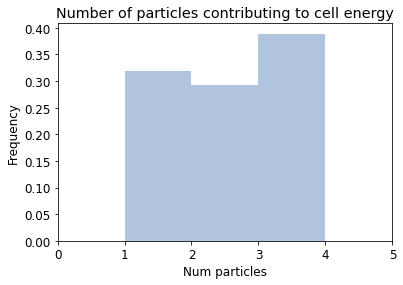

In [116]:
# number of particles contributing to each cell
num_truth_contributions = np.array([[len(cell_truth_con) for cell_truth_con in event_truth_con] for event_truth_con in processed_event_data["cell_hitsTruthIndex"]])
pu.plot_hist(flatten_one_layer(num_truth_contributions), 3, "Number of particles contributing to cell energy", "Num particles", "Frequency", xlim=(0, 5), colour="lightsteelblue", discrete=True)

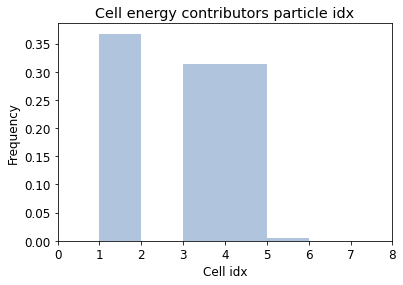

36.748% of energy contributions are from the charged pion and 63.252% are from the gammas


In [117]:
# Of these particles which are depositing energy into the cells
# idx: 0-rho, 1-pi+/-, 2-pi0, 3-gamma, 4-gamma, 5-gamma
truth_part_name = { 0: "rho+/-", 1: "pi+/-", 2: "pi0", 3: "gamma1", 4: "gamma2", 5: "gamma3", 6: "gamma4" }
cell_energy_contr_part_idx = np.array(flatten_layers(processed_event_data["cell_hitsTruthIndex"], 2))
pu.plot_hist(cell_energy_contr_part_idx, 6, "Cell energy contributors particle idx", "Cell idx", "Frequency", colour="lightsteelblue", xlim=(0,8), discrete=True) 
print(str(round((len(cell_energy_contr_part_idx[cell_energy_contr_part_idx == 1])/len(cell_energy_contr_part_idx))*100, 3)) + "% of energy contributions are from the charged pion and " + str(round((len(cell_energy_contr_part_idx[cell_energy_contr_part_idx != 1])/len(cell_energy_contr_part_idx))*100, 3)) + "% are from the gammas")


In [21]:
# how much energy are these single particles depositing into the cells
part_energy_deposits = np.array(flatten_layers(processed_event_data["cell_hitsTruthE"], 2))
pu.plot_hist(part_energy_deposits, 100, "Energy deposits by one particle into one cell", "Energy (MeV)", "Frequency", colour="lightsteelblue")
pu.plot_hist(part_energy_deposits[part_energy_deposits < 2000], 100, "Energy deposits by one particle into one cell (< 2000)", "Energy (MeV)", "Frequency", colour="#009fdf")


KeyboardInterrupt: 

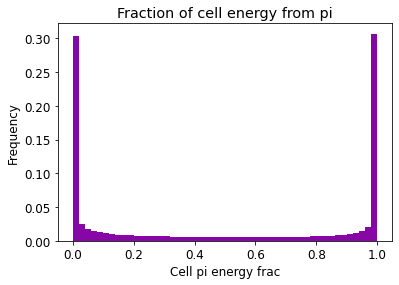

frac with 1 part contr: 0.0


In [141]:
flat_frac_pi0_energy = flatten_layers(processed_event_data["frac_pi0_energy"], 1)
pu.plot_hist(np.array(flat_frac_pi0_energy), 50, "Fraction of cell energy from pi", "Cell pi energy frac", "Frequency", colour="#8707A6FF") # add threshold at 0.5

print("frac with 1 part contr:", np.count_nonzero((flat_frac_pi0_energy == 0) or (flat_frac_pi0_energy == 1))/len(flat_frac_pi0_energy))
print("frac with 1 part contr:", np.count_nonzero((flat_frac_pi0_energy < 0.1) or (flat_frac_pi0_energy > 0.9))/len(flat_frac_pi0_energy))

frac cells pi0 class: 0.4917973698690906
frac cells pi+/- class: 0.5082026301309094


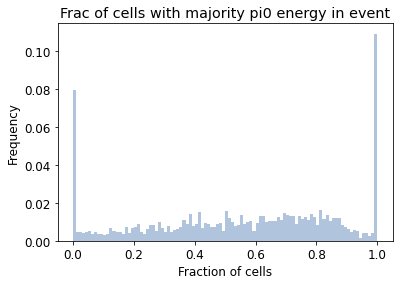

In [120]:
class_frac_pi0_energy = ak.Array(processed_event_data["class_frac_pi0_energy"])

print("frac cells pi0 class:", np.count_nonzero(class_frac_pi0_energy)/len(flatten_one_layer(class_frac_pi0_energy)))
print("frac cells pi+/- class:", 1 - np.count_nonzero(class_frac_pi0_energy)/len(flatten_one_layer(class_frac_pi0_energy)))

frac_cells_majority_pi0_in_event = np.array([np.count_nonzero(class_frac_pi0_energy_event)/len(class_frac_pi0_energy_event) for class_frac_pi0_energy_event in processed_event_data["class_frac_pi0_energy"]])
pu.plot_hist(frac_cells_majority_pi0_in_event, 100, "Frac of cells with majority pi0 energy in event", "Fraction of cells", "Frequency", colour="lightsteelblue")


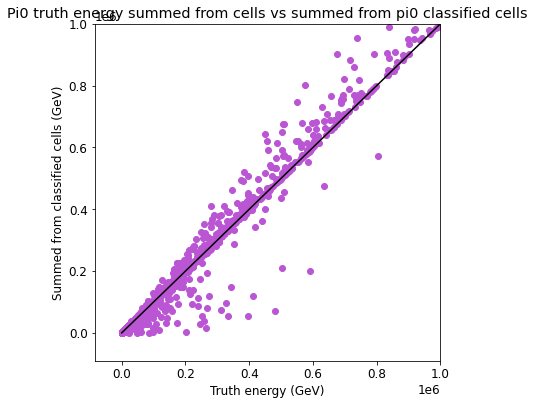

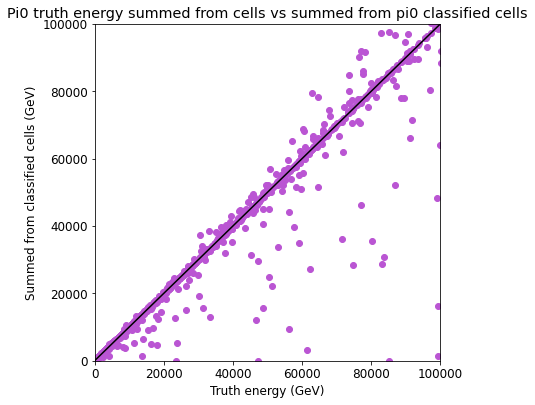

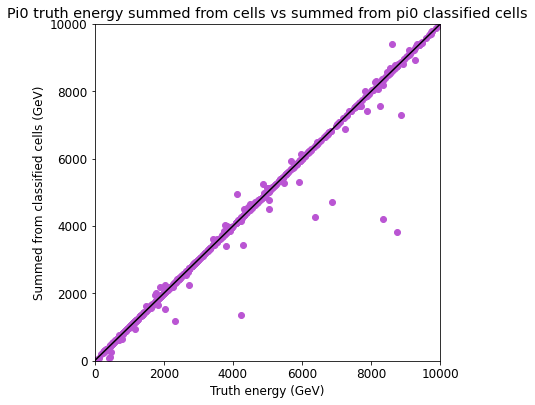

In [121]:
# distribute cell energy based on classification and compare to truth energy of the event
pi0_event_energy_based_on_classification = [np.sum(event_truth_E_deposits, axis=None) for event_truth_E_deposits in ak.Array(processed_event_data["cell_hitsTruthE"])[class_frac_pi0_energy == 1]]
pi0_event_truth_energy = [np.sum(event_truth_E_deposits[processed_event_data["cell_hitsTruthIndex"][event_idx] != 1]) for event_idx, event_truth_E_deposits in enumerate(ak.Array(processed_event_data["cell_hitsTruthE"]))]

plot_truth_E_comparison(pi0_event_truth_energy, pi0_event_energy_based_on_classification, "Pi0 truth energy summed from cells vs summed from pi0 classified cells","Truth energy (GeV)", "Summed from classified cells (GeV)", (None, 1000000))
plot_truth_E_comparison(pi0_event_truth_energy, pi0_event_energy_based_on_classification, "Pi0 truth energy summed from cells vs summed from pi0 classified cells","Truth energy (GeV)", "Summed from classified cells (GeV)", (0, 100000))
plot_truth_E_comparison(pi0_event_truth_energy, pi0_event_energy_based_on_classification, "Pi0 truth energy summed from cells vs summed from pi0 classified cells","Truth energy (GeV)", "Summed from classified cells (GeV)", (0, 10000))

In [122]:
# get event idxs where all cells are pi+/- or pi0
frac_cells_fully_pi0_in_event = np.array([np.count_nonzero(np.array(frac_pi0_energy_event) == 1)/len(frac_pi0_energy_event) for frac_pi0_energy_event in processed_event_data["frac_pi0_energy"]])
frac_cells_fully_pipm_in_event = np.array([np.count_nonzero(np.array(frac_pi0_energy_event) == 0)/len(frac_pi0_energy_event) for frac_pi0_energy_event in processed_event_data["frac_pi0_energy"]])

event_idx = np.arange(len(processed_event_data["cell_hitsTruthE"]))

events_with_all_pi0_deposits = event_idx[frac_cells_fully_pi0_in_event == 1]
events_with_all_pipm_deposits = event_idx[frac_cells_fully_pipm_in_event == 1]

Post-train analysis

In [110]:
THRESHOLD_PI0_FRAC = 0.5

# event/cluster/cell flattening functions
def flatten_events_to_clus(events_data):
    return [clus_data for event_data in events_data for clus_data in event_data]

def flatten_events_to_cells(events_data):
    return [cell_data for clus_data in flatten_events_to_clus(events_data) for cell_data in clus_data]

def flatten_events_and_clus_to_events(events_data):
    return [[cell_data for clus_data in event_data for cell_data in clus_data] for event_data in events_data]

# train loss/acc analysis plots
def get_accuracy(preds, labels):
    #correct = []
    #for i, pred in enumerate(preds):
    #    acc = (pred <= 0.5)*(1 - labels[i]) + (pred > 0.5)*labels[i]
    #    correct.append(acc)
    #return sum(correct) / len(correct) 

    correct = (np.array(preds) > 0.5) == np.array(labels)
    return np.count_nonzero(correct)/len(correct)

def get_masked_pointwise_bce(preds, labels):
    epsilon = 1e-7#np.exp(-20)
    bce = -(labels*np.log(preds + epsilon) + (1-labels)*np.log(1-preds + epsilon))
    
    return bce

def get_masked_weighted_pointwise_bce(preds, truth):
    labels = np.expand_dims(truth[:, :, 0], -1)
    weights = np.expand_dims(truth[:, :, 1], -1)
    unmasked = labels != MASK_OUT
    epsilon = 1e-7#np.exp(-20)
    preds = preds[unmasked]
    labels = labels[unmasked]
    weights = weights[unmasked]
    bce = -weights*(labels*np.log(preds + epsilon) + (1-labels)*np.log(1-preds + epsilon))
    
    return bce

# plot train and val loss over epoch
def plot_train_and_val_loss(train_loss, val_loss):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_loss, label="Train", color="#009fdf")
    plt.plot(val_loss, label="Val", color="#F2705D")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title("Training loss")
    plt.show()

def plot_train_and_val_acc(train_acc, val_acc):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(train_acc, label="train")
    plt.plot(val_acc, label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def plot_accuracy(preds, labels):
    accuracy = []
    for epoch_preds in preds:
        accuracy.append(get_accuracy(epoch_preds, labels))
    print("accuracy:", accuracy)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(accuracy, color="#009fdf")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Classification accuracy")
    plt.show()

def plot_test_loss(preds, labels):
    test_loss = []
    for epoch_preds in preds:
        test_loss.append(np.mean(get_masked_pointwise_bce(epoch_preds, labels)))
    print("test loss:", test_loss)
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(test_loss)
    plt.xlabel("epoch")
    plt.ylabel("test loss")
    plt.show()

def plot_event_frac_em_class(preds_unmasked, labels_unmasked):
    frac_events_all_low_em_class = []
    frac_events_all_high_em_class = []
    for epoch_preds in preds_unmasked:
        pred_em_frac = np.array([np.sum([pred > 0.5 for pred in epoch_preds[i][event_labels != -1]]) / len(event_labels[event_labels != -1]) for i, event_labels in enumerate(labels_unmasked)])
        frac_events_all_low_em_class.append(len(pred_em_frac[pred_em_frac == 0]) / len(pred_em_frac))
        frac_events_all_high_em_class.append(len(pred_em_frac[pred_em_frac == 1]) / len(pred_em_frac))
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(frac_events_all_low_em_class, label="All low em class", color="darkseagreen")
    plt.plot(frac_events_all_high_em_class, label="All high em class", color="orchid")
    plt.plot(np.array(frac_events_all_low_em_class) + np.array(frac_events_all_high_em_class), color="grey")
    plt.xlabel("epoch")
    plt.ylabel("Frac events with all cells pred same class")
    plt.legend()
    plt.show()

def train_summary_stats(model_file_path, num_epochs, load_acc=False):
    # load all train data
    loss_data = genfromtxt(model_file_path + "/log_loss.csv", delimiter=',').transpose()
    loss = loss_data[1]
    val_loss = loss_data[2]
    plot_train_and_val_loss(loss, val_loss)

    if load_acc:
        acc_data = genfromtxt(model_file_path + "/log_accuracy.csv", delimiter=',').transpose()
        acc = acc_data[1]
        val_acc = acc_data[2]
        plot_train_and_val_acc(acc, val_acc)
    
    labels_unmasked = np.load(model_file_path + "/tests/labels.npy")
    #labels_unmasked = labels_unmasked[:, :1615, :]
    preds_unmasked = []
    preds = []
    for epoch in range(num_epochs):
        epoch_preds = np.load(model_file_path + "/tests/preds_" + str(epoch) + ".npy")
        #epoch_preds = epoch_preds[:, :1615, :] # temp cut
        preds_unmasked.append(epoch_preds)
        preds.append(epoch_preds[labels_unmasked != -1])
    labels = labels_unmasked[labels_unmasked != -1]

    if not load_acc:
        #plot_test_loss(preds, labels)
        plot_accuracy(preds, labels)
    plot_event_frac_em_class(preds_unmasked, labels_unmasked)

def get_cut_count(EM_frac, p_yi, cut_EM_frac_low, cut_EM_frac_high, cut_p_yi_low, cut_p_yi_high):
    EM_frac = np.array(EM_frac)
    p_yi = np.array(p_yi)
    point_cut = (EM_frac >= cut_EM_frac_low) & (EM_frac < cut_EM_frac_high) & (p_yi >= cut_p_yi_low) & (p_yi < cut_p_yi_high)
    return len(EM_frac[point_cut])

def plot_pi0_frac_vs_preds(pi0_frac, preds, title="All cells", bins=(50,50)):

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(pi0_frac, preds, bins, cmap=plt.cm.magma_r, norm=mpl.colors.LogNorm())

    plt.axvline(x=THRESHOLD_PI0_FRAC, color='grey')
    plt.axhline(y=0.5, color='grey')
    
    plt.ylim((0,1))
    plt.colorbar(label="frequency")
    plt.xlabel("Pi0 frac")
    plt.ylabel("P(pi0 frac >= " + str(THRESHOLD_PI0_FRAC) + ")")
    plt.title("All cells")
    plt.show()

def plot_pi0_frac_vs_preds_normalize_col(em_frac, preds, title="All cells", bins=(50,50)):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    hist, xedges, yedges = np.histogram2d(em_frac, preds, bins, range=((0,1), (0,1)))
    for i in range(hist.shape[0]):
        hist[i, :] = hist[i, :] / np.sum(hist[i, :])

    plt.plot(x,y,'wo',alpha=0.3)
    plt.imshow(hist.T, 
               extent=[xedges.min(),xedges.max(),yedges.min(),yedges.max()],
               origin='lower', 
               interpolation='nearest', 
               cmap=plt.cm.terrain_r,
               vmin=0,
               vmax=1,
               aspect='auto')
    
    #plt.imshow(hist, cmap=plt.cm.magma)
    plt.axvline(x=THRESHOLD_PI0_FRAC, color='grey')
    plt.axhline(y=0.5, color='grey')

    plt.ylim((0,1))
    plt.colorbar(label="frequency")
    plt.xlabel("Pi0 frac")
    plt.ylabel("P(pi0 frac >= " + str(THRESHOLD_PI0_FRAC) + ")")
    plt.title(title)
    plt.show()

def plot_preds_hist_cut_em_frac(preds, em_frac, em_frac_low, em_frac_high, bins=50):
    em_frac = np.array(em_frac)
    em_frac_cut = (em_frac >= em_frac_low) & (em_frac < em_frac_high)
    pu.plot_hist(preds[em_frac_cut], bins, str(round(em_frac_low, 3)) + " <= truth em frac < " + str(round(em_frac_high, 3)), "P(EM frac >= 0.9481)", "frequency", colour="darkseagreen")
    
def plot_accuracy_over_pi0_cut(preds, labels, pi0_frac, num_points):
    em_frac = np.array(pi0_frac)
    accuracy = []

    for i in range(num_points):
        em_frac_cut = (em_frac >= i*(1/num_points)) & (em_frac < (i+1)*(1/num_points))
        accuracy.append(get_accuracy(preds[em_frac_cut], labels[em_frac_cut]))
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(np.arange(1/num_points, 1 + (1/num_points), 1/num_points), accuracy, color="#009fdf", linewidth=2.5)
    plt.axvline(x=THRESHOLD_PI0_FRAC, color='grey', linewidth='0.5')
    plt.xlabel("Cell pi energy frac")
    plt.ylabel("Accuracy")
    plt.title("Fraction of cell energy from pi vs classification accuracy")
    plt.xlim((-0.1, 1.1))
    plt.show()


def plot_accuracy_over_cut(preds, labels, event_cut_data, num_points, title, xlabel, xlim=None):
    event_cut_data = np.array(event_cut_data)
    accuracy = []
    cut_at = []

    max_event_cut_data = np.max(event_cut_data)
    cut_size = max_event_cut_data / num_points

    for i in range(num_points):
        cut = (event_cut_data >= i*cut_size) & (event_cut_data < (i+1)*cut_size)
        if np.count_nonzero(cut) > 0:
            accuracy.append(get_accuracy(preds[cut], labels[cut]))
            cut_at.append(i*cut_size)
    

    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.hist2d(cut_at, accuracy, 75, cmap=plt.cm.magma_r)
    plt.colorbar(label="frequency")

    
    accuracy = []
    cut_at = []
    num_points = 50
    cut_size = max_event_cut_data / num_points
    for i in range(num_points):
        cut = (event_cut_data >= i*cut_size) & (event_cut_data < (i+1)*cut_size)
        if np.count_nonzero(cut) > 0:
            accuracy.append(get_accuracy(preds[cut], labels[cut]))
            cut_at.append(i*cut_size)
       
    plt.plot(cut_at, accuracy, color="black")
    
    plt.xlabel(xlabel)
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.show()


def plot_quadrent_info(preds, pi0_frac, bin_size=50):
    # if plotting p(yi) output accuracy for each quandrant
    bin_size = 1 / bin_size

    plt.rcParams["figure.figsize"] = [4, 1]
    font = {'size'   : 16}
    mpl.rc('font', **font)

    # count freq at in quadrant
    print("quadrants")
    bottom_left = get_cut_count(pi0_frac, preds, 0, THRESHOLD_PI0_FRAC, 0, bin_size*25)
    top_left = get_cut_count(pi0_frac, preds, 0, THRESHOLD_PI0_FRAC, bin_size*25, 1.1)
    bottom_right = get_cut_count(pi0_frac, preds, THRESHOLD_PI0_FRAC, 1.1, 0, bin_size*25)
    top_right = get_cut_count(pi0_frac, preds, THRESHOLD_PI0_FRAC, 1.1, bin_size*25, 1.1)

    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    table = axs.table(cellText=[[round(top_left/len(pi0_frac), 4), round(top_right/len(pi0_frac), 4)], 
        [round(bottom_left/len(pi0_frac), 4), round(bottom_right/len(pi0_frac), 4)]], loc='center')
    table.scale(1,2)
    plt.show()

    # count freq at corner points
    print("corners")
    point_0_0 = get_cut_count(pi0_frac, preds, 0, bin_size, 0, bin_size)
    point_0_1 = get_cut_count(pi0_frac, preds, 0, bin_size, 1 - bin_size, 1.1)
    point_1_0 = get_cut_count(pi0_frac, preds, 1 - bin_size, 1.1, 0, bin_size)
    point_1_1 =  get_cut_count(pi0_frac, preds, 1 - bin_size, 1.1, 1 - bin_size, 1.1)

    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    
    table = axs.table(cellText=[[round(point_0_1/len(pi0_frac), 4), round(point_1_1/len(pi0_frac), 4)],
        [round(point_0_0/len(pi0_frac), 4), round(point_1_0/len(pi0_frac), 4)]], loc='center')
    table.scale(1,2)
    plt.show()

    plt.rcParams["figure.figsize"] = [6,4]
    font = {'size'   : 12}
    mpl.rc('font', **font)

    # sum check
    #print("Total cells (len(em_frac)):", len(em_frac))
    #print("Total cells in quadrants:", bottom_left + top_left + bottom_right + top_right)

    # class accuracy
    #print("Left class accuracy [P(EM frac < 0.9481)]:", bottom_left / (bottom_left + top_left))
    #print("Right class accuracy [P(EM frac >= 0.9481)]:", top_right / (bottom_right + top_right))

def plot_cut_accuracies(preds, labels, em_frac):
    # get cuts
    neutral_cut_cellwise = []
    for event_idx, clus_truth_part in enumerate(processed_event_data["truth_particle"]):
        for cluster_idx, truth_particle in enumerate(clus_truth_part):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][event_idx][cluster_idx])))
    neutral_cut_cellwise = np.array(neutral_cut_cellwise)

    em_class_cut = (np.array(labels) == 1)

    em_frac_one = (em_frac == 1)

    accuracies = [["", "Had class", "EM class", "EM frac = 1", str(THRESHOLD_EM_FRAC) + " <= EM frac < 1", "Both classes"]]
    if mixed:
        accuracies.append(["Neutral", round(get_accuracy(preds[neutral_cut_cellwise & ~em_class_cut], labels[neutral_cut_cellwise & ~em_class_cut]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise & em_class_cut], labels[neutral_cut_cellwise & em_class_cut]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise & em_frac_one], labels[neutral_cut_cellwise & em_frac_one]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise & em_class_cut & ~em_frac_one], labels[neutral_cut_cellwise & em_class_cut & ~em_frac_one]), 3),
                    round(get_accuracy(preds[neutral_cut_cellwise], labels[neutral_cut_cellwise]), 3)])
        accuracies.append(["Charged", round(get_accuracy(preds[~neutral_cut_cellwise & ~em_class_cut], labels[~neutral_cut_cellwise & ~em_class_cut]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise & em_class_cut], labels[~neutral_cut_cellwise & em_class_cut]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise & em_frac_one], labels[~neutral_cut_cellwise & em_frac_one]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise & em_class_cut & ~em_frac_one], labels[~neutral_cut_cellwise & em_class_cut & ~em_frac_one]), 3),
                    round(get_accuracy(preds[~neutral_cut_cellwise], labels[~neutral_cut_cellwise]), 3)])
        
    accuracies.append(["Mixed", round(get_accuracy(preds[~em_class_cut], labels[~em_class_cut]), 3),
    round(get_accuracy(preds[em_class_cut], labels[em_class_cut]), 3),
    round(get_accuracy(preds[em_frac_one], labels[em_frac_one]), 3),
    round(get_accuracy(preds[em_class_cut & ~em_frac_one], labels[em_class_cut & ~em_frac_one]), 3),
    round(get_accuracy(preds, labels), 3)])
    
    if mixed:
        plt.rcParams["figure.figsize"] = [20, 2]
    else:
        plt.rcParams["figure.figsize"] = [20, 1]
    font = {'size'   : 16}
    mpl.rc('font', **font)

    print("accuracies:")
    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    
    table = axs.table(cellText=accuracies, loc='center')
    table.scale(1,2)
    plt.show()

    plt.rcParams["figure.figsize"] = [6,4]
    font = {'size'   : 12}
    mpl.rc('font', **font)


def plot_filtered_em_frac_vs_preds(preds, em_frac, filter="None", title=None, xlabel="", bins=75):
    if filter == "None":
        plot_em_frac_vs_preds(preds, em_frac, "All cells")

    if filter == "truth_particle":
        neutral_cut_cellwise = []
        for cluster_idx, truth_particle in enumerate(processed_event_data["truth_particle"]):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][cluster_idx])))
        neutral_cut_cellwise = np.array(neutral_cut_cellwise)

        plot_em_frac_vs_preds(em_frac[neutral_cut_cellwise], preds[neutral_cut_cellwise], "Neutral pions")
        plot_em_frac_vs_preds(em_frac[neutral_cut_cellwise], preds[neutral_cut_cellwise], "Charged pions")
    if filter == "EM_frac_0.5" or filter == "EM_frac_class":
        if filter == "EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        truth_EM_frac_cellwise = np.array([cell_data for clus_data in processed_event_data["truth_EM_frac"] for cell_data in clus_data])
        em_cut_cellwise = truth_EM_frac_cellwise > threshold
        plot_em_frac_vs_preds(em_frac[em_cut_cellwise], preds[em_cut_cellwise], "EM > " + str(threshold))
        plot_em_frac_vs_preds(em_frac[~em_cut_cellwise], preds[~em_cut_cellwise], "EM <= " + str(threshold))

    if filter == "clus_mean_EM_frac_0.5" or filter == "clus_mean_EM_frac_class":
        if filter == "clus_mean_EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        em_cut_clusterwise = []
        for clus_EM_frac in processed_event_data["truth_EM_frac"]:
            em_cut_clusterwise.extend(np.tile(np.mean(clus_EM_frac) > threshold, len(clus_EM_frac)))
        em_cut_clusterwise = np.array(em_cut_clusterwise)

        plot_em_frac_vs_preds(em_frac[em_cut_clusterwise], preds[em_cut_clusterwise], "clus mean EM > " + str(threshold))
        plot_em_frac_vs_preds(em_frac[~em_cut_clusterwise], preds[~em_cut_clusterwise], "clus mean EM <= " + str(threshold))


def plot_cellwise_hist(cellwise_data, filter="None", title=None, xlabel="", bins=75):
    if filter == "None":
        pu.plot_hist(cellwise_data, 50, title, xlabel, "frequency")

    if filter == "truth_particle":
        neutral_cut_cellwise = []
        for cluster_idx, truth_particle in enumerate(processed_event_data["truth_particle"]):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][cluster_idx])))
        neutral_cut_cellwise = np.array(neutral_cut_cellwise)
        pu.plot_overlay_hist([cellwise_data[neutral_cut_cellwise], cellwise_data[~neutral_cut_cellwise]], bins, title, xlabel, "frequency", ["neutral", "charged"])

    if filter == "EM_frac_0.5" or filter == "EM_frac_class":
        if filter == "EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        truth_EM_frac_cellwise = np.array([cell_data for clus_data in processed_event_data["truth_EM_frac"] for cell_data in clus_data])
        em_cut_cellwise = truth_EM_frac_cellwise > threshold
        pu.plot_overlay_hist([cellwise_data[em_cut_cellwise], cellwise_data[~em_cut_cellwise]], bins, title, xlabel, "frequency", ["EM > " + str(threshold), "EM <= " + str(threshold)])

    if filter == "clus_mean_EM_frac_0.5" or filter == "clus_mean_EM_frac_class":
        if filter == "clus_mean_EM_frac_0.5":
            threshold = 0.5
        else:
            threshold = THRESHOLD_EM_FRAC
        em_cut_clusterwise = []
        for clus_EM_frac in processed_event_data["truth_EM_frac"]:
            em_cut_clusterwise.extend(np.tile(np.mean(clus_EM_frac) > threshold, len(clus_EM_frac)))
        em_cut_clusterwise = np.array(em_cut_clusterwise)
        pu.plot_overlay_hist([cellwise_data[em_cut_clusterwise], cellwise_data[~em_cut_clusterwise]], bins, title, xlabel, "frequency", ["clus mean EM > " + str(threshold), "clus mean EM <= " + str(threshold)])

def plot_roc(preds, labels):
    fp, tp, threshs = roc_curve(labels, preds)
    auc = roc_auc_score(labels, preds)
    print('auc:', auc)

    # compute frac correct classifications for each threshold
    #corr = list(map(lambda thresh: accuracy_score(labels, list(map(lambda pred: pred > thresh, preds))), threshs))
    #print("max acc:", np.max(corr)) 

    # 1) basic roc
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.scatter(fp, tp, linewidth=0.25, color="lightsteelblue")
    plt.title('roc')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    # 2) signal efficiency vs 1/background efficiency (1/[1-fpr])
    invs_back_eff = np.log10(1 / fp[1:]) # first fp = 0

    # filter out all singal efficiencies < 0.6
    sig_effs = tp[1:]
    rejects = []
    #thresholds = []
    #for i, sig_eff in enumerate(tp):
    #    if sig_eff > 0.6:
    #        sig_effs.append(sig_eff)
    #        rejects.append(invs_back_eff[i])
    #        #thresholds.append(threshs[i])

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.scatter(sig_effs, invs_back_eff, linewidth=0.25, color="lightsteelblue")#, c=thresholds)
    plt.title('roc')
    plt.xlabel('signal efficiency (TPR)')
    plt.ylabel('log10[1/(1 - background efficiency)] (1/FPR)')
    plt.show()

def plot_clus_em_frac_mean_cut_class_similar(em_frac, cut_class_similar_low, cut_class_similar_high, bins=50):
    cut_clus = [(cut_class_similar_low <= (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high) or
                (cut_class_similar_low <= (np.sum(clus_em_frac <= THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac < THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high)
            for clus_em_frac in em_frac]


    clus_em_frac_mean = np.array([np.mean(clus_em_frac) for clus_em_frac in em_frac])[cut_clus]

    em_class_clus_em_frac_mean = np.array([np.mean(clus_em_frac[np.array(clus_em_frac) > THRESHOLD_EM_FRAC]) for clus_em_frac in em_frac])[cut_clus]
    had_class_clus_em_frac_mean = np.array([np.mean(clus_em_frac[np.array(clus_em_frac) <= THRESHOLD_EM_FRAC]) for clus_em_frac in em_frac])[cut_clus]


    pu.plot_hist(clus_em_frac_mean, bins, "clusters with " + str(cut_class_similar_low) + " <= similarity < " + str(cut_class_similar_high), "clus mean cell em frac", "frequency", True, "darkseagreen", (0,1))
    pu.plot_overlay_hist([em_class_clus_em_frac_mean, had_class_clus_em_frac_mean], bins, "clusters with " + str(cut_class_similar_low) + " <= similarity < " + str(cut_class_similar_high), "clus mean cell em frac", "frequency", ["em class", "had class"], ["darkseagreen", "orchid"], (0,1))

def plot_clus_cell_em_frac_cut_class_similar(em_frac, cut_class_similar_low, cut_class_similar_high, num_clus, bins=50):
    cut_clus = [(cut_class_similar_low <= (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac > THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high) or
                (cut_class_similar_low <= (np.sum(clus_em_frac <= THRESHOLD_EM_FRAC) / len(clus_em_frac)) and (np.sum(clus_em_frac < THRESHOLD_EM_FRAC) / len(clus_em_frac)) <= cut_class_similar_high)
            for clus_em_frac in em_frac]
    
    
    colour_cycle = ["darkseagreen", "orchid", "lightsteelblue", "lightsalmon", "darkviolet", "darkcyan"]    

    i = 0
    clus_idx = 0
    clus_cell_em_frac = []
    labels = []
    colours = []

    while num_clus != 0:
        if cut_clus[clus_idx]:
            clus_cell_em_frac.append(em_frac[clus_idx])
            labels.append("cluster " + str(clus_idx))
            colours.append(colour_cycle[i])
            num_clus -= 1
            i += 1
        clus_idx += 1

    pu.plot_overlay_hist(clus_cell_em_frac, bins, "clusters with " + str(cut_class_similar_low) + " <= similarity <= " + str(cut_class_similar_high), "cell em frac", "frequency", labels, colours, (0,1))

def plot_clus_similarity_distribution(preds, labels, bins):
    clus_frac_em_class = np.array([np.sum(clus_labels[clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for clus_labels in labels])
    clus_frac_pred_em_class = np.array([np.sum([pred > 0.5 for pred in preds[i][clus_labels != -1]]) / len(clus_labels[clus_labels != -1]) for i, clus_labels in enumerate(labels)])
    

    pu.plot_hist(clus_frac_em_class, 200, "Truth classes in event", "Fraction of cells with pi class", "Frequency", True, "#8707A6FF", (-0.1,1.1)) # #009fdf
    pu.plot_hist(clus_frac_pred_em_class, 200, "Predicted classes in event", "Fraction of cells with pi class", "Frequency", True, "#8707A6FF", (-0.1,1.1))#, (np.min(clus_frac_pred_em_class), np.max(clus_frac_pred_em_class))))
    
    # plot 2d distribution vs cellwise accuracy
    clus_mean_acc = np.array([get_accuracy(clus_preds[labels[i] != -1], labels[i][labels[i] != -1]) for i, clus_preds in enumerate(preds)])

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(clus_frac_em_class, clus_mean_acc, (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
    plt.colorbar(label="Frequency")
    plt.xlabel("Fraction of cells with pi class")
    plt.ylabel("Mean cell accuracy")
    plt.title("All events")
    plt.show()


def plot_clus_preds_similarity_distribution(preds, labels, bins):
    clus_frac_pred_em_class = np.array([np.sum(preds[i][clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for i, clus_labels in enumerate(labels)])

    pu.plot_hist(clus_frac_pred_em_class, bins, "All events - predicted classes", "event frac of cells with em class", "frequency", True, "darkseagreen", (-0.1,1.1))
    
    if mixed:
        neutral_clus_cut =  np.array([clus_truth_particles[0] == 0 for clus_truth_particles in processed_event_data["truth_particle"]])
        pu.plot_overlay_hist([clus_frac_pred_em_class[neutral_clus_cut], clus_frac_pred_em_class[~neutral_clus_cut]], bins, "", "event frac of cells with em class", "frequency", ["neutral", "charged"], ["darkseagreen", "orchid"], (0,1), "upper left")
    
    # plot 2d distribution vs cellwise accuracy
    clus_mean_acc = np.array([get_accuracy(clus_preds, labels[i]) for i, clus_preds in enumerate(preds)])

    #print("mean clus acc:", np.mean(clus_mean_acc))
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(clus_frac_pred_em_class, clus_mean_acc, (bins, bins), range=((0,1),(0,1)), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
    plt.colorbar(label="frequency")
    plt.xlabel("event frac of cells with em class")
    plt.ylabel("event mean accuracy")
    plt.title("All events")
    plt.show()

def plot_clus_info_dist(preds, labels, em_frac_data, clus_frac_em_class_cut_low, clus_frac_em_class_cut_high, clus_mean_acc_cut_low, clus_mean_acc_cut_high, bins=50, title=""):
    clus_frac_em_class = np.array([np.sum(clus_labels[clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for clus_labels in labels])
    clus_mean_acc = np.array([get_accuracy(clus_preds, labels[i]) for i, clus_preds in enumerate(preds)])

    clus_num_cells = np.array([len(clus_labels[clus_labels != -1]) for clus_labels in labels])
    clus_mean_cell_em_frac = np.array([np.mean(clus_truth_em_frac) for clus_truth_em_frac in em_frac_data])

    clus_cut = (clus_frac_em_class_cut_low <= clus_frac_em_class) & (clus_frac_em_class < clus_frac_em_class_cut_high) & (clus_mean_acc_cut_low <= clus_mean_acc) & (clus_mean_acc < clus_mean_acc_cut_high)
    
    pu.plot_hist(clus_num_cells[clus_cut], bins, title, "num cells", "frequency", colour="darkseagreen")
    pu.plot_hist(clus_mean_cell_em_frac[clus_cut][clus_mean_cell_em_frac[clus_cut] >0.98], bins, title, "mean cell em frac", "frequency", colour="darkseagreen")

def get_neutral_cell_cut():
    neutral_cut_cellwise = []
    for event_idx, clus_truth_part in enumerate(processed_event_data["truth_particle"]):
        for cluster_idx, truth_particle in enumerate(clus_truth_part):
            neutral_cut_cellwise.extend(np.tile(not truth_particle, len(processed_event_data["truth_EM_frac"][event_idx][cluster_idx])))
    return np.array(neutral_cut_cellwise)

def get_baseline_accuracy():
    events_em_class_frac = [np.sum(event_em_frac_class)/len(event_em_frac_class) for event_em_frac_class in flatten_events_and_clus_to_events(processed_event_data["truth_EM_frac_class"])]
    majority_class_frac = [max(event_em_class_frac, 1 - event_em_class_frac) for event_em_class_frac in events_em_class_frac]
    return np.mean(majority_class_frac)

def get_cross_plot_quadrent_info(preds, labels, class_frac_pi0_energy, num_idxs=5, num_bins=50, event_idx=0):
    em_frac = np.around(np.array([np.sum(event_em_frac_class)/len(event_em_frac_class) for event_em_frac_class in class_frac_pi0_energy]), 5)
    had_frac = np.around(1 - em_frac, 5)
    acc = np.around(np.array([get_accuracy(event_preds[labels[i] != -1], labels[i][labels[i] != -1]) for i, event_preds in enumerate(preds)]), 5)

    # debug a certain event
    """
    print("event:", event_idx)
    print("event acc:", acc[event_idx])
    print("event frac em class:", em_frac[event_idx])
    print("event frac had class:", had_frac[event_idx])
    
    print("in quad 2:", ((em_frac[event_idx] < 0.5) & (acc[event_idx] < em_frac[event_idx])) | ((em_frac[event_idx] >= 0.5) & (acc[event_idx] < had_frac[event_idx])))
    print("acc == 1 - em_frac:", acc[event_idx] == had_frac[event_idx])
    """

    num_events = len(em_frac)
    idxs = np.arange(num_events)
    quad_1 = ((em_frac < 0.5) & (acc > had_frac)) | ((em_frac >= 0.5) & (acc > em_frac))
    quad_2 = ((em_frac < 0.5) & (acc < em_frac)) | ((em_frac >= 0.5) & (acc < had_frac))
    quad_3 = (em_frac < 0.5) & (acc < had_frac) & (acc > em_frac)
    quad_4 = (em_frac > 0.5) & (acc < em_frac) & (acc > had_frac)

    line_1 = (em_frac < 0.5) & (acc == em_frac)
    line_2 = (em_frac < 0.5) & (acc == had_frac)
    line_3 = (em_frac > 0.5) & (acc == em_frac)
    line_4 = (em_frac > 0.5) & (acc == had_frac)

    bottom_left = (em_frac < 1/num_bins) & (acc == em_frac)
    top_left = (em_frac < 1/num_bins) & (acc == had_frac)
    bottom_right = (em_frac > (num_bins - 1)/num_bins) & (acc == had_frac)
    top_right = (em_frac > (num_bins - 1)/num_bins) & (acc == em_frac)

    mid_point = (em_frac == 0.5) & (acc == em_frac)

    cuts = [quad_1, quad_2, quad_3, quad_4, line_1, line_2, line_3, line_4, mid_point, bottom_left, top_left, bottom_right, top_right]
    cut_names = ["quad_1", "quad_2", "quad_3", "quad_4", "line_1", "line_2", "line_3", "line_4", "mid_point", "bottom_left", "top_left", "bottom_right", "top_right"]

    # print size of each cut - normalized to be frac of events
    sum_event_fracs = 0
    event_fracs = {}
    for i, cut in enumerate(cuts):
        event_frac = round(cut.sum()/num_events, 3)
        #print(cut_names[i] + ":", event_frac)
        if i < 9:
            sum_event_fracs += event_frac
        else:
            print(cut_names[i] + ":", event_frac)

        event_fracs[cut_names[i]] = event_frac
    print("sum of event fracs:", sum_event_fracs)

    # make table of event fracs
    plt.rcParams["figure.figsize"] = [4, 1.5]
    font = {'size'   : 16}
    mpl.rc('font', **font)

    fig, axs = plt.subplots(1, 1)
    fig.patch.set_facecolor('white')
    axs.axis('tight')
    axs.axis('off')
    
    event_fracs_format = [[event_fracs["line_2"], event_fracs["quad_1"], event_fracs["line_3"]],
                          [event_fracs["quad_3"], event_fracs["mid_point"], event_fracs["quad_4"]],
                          [event_fracs["line_1"], event_fracs["quad_2"], event_fracs["line_4"]]]
    
    table = axs.table(cellText=event_fracs_format, loc='center')
    table.scale(1,2)
    plt.show()

    plt.rcParams["figure.figsize"] = [6,4]
    font = {'size'   : 12}
    mpl.rc('font', **font)
    print()

    pred_em_frac = np.array([np.sum([pred > 0.5 for pred in preds[i][clus_labels != -1]]) / len(clus_labels[clus_labels != -1]) for i, clus_labels in enumerate(labels)])
    print("% events all low em class:", round(len(pred_em_frac[pred_em_frac == 0]) / len(pred_em_frac), 5))
    print("% events all high em class:", round(len(pred_em_frac[pred_em_frac == 1]) / len(pred_em_frac), 5))
    print("% events falsey all low em class:", round(len(pred_em_frac[(pred_em_frac == 0) & (em_frac != 0)]) / len(pred_em_frac), 5))
    print("% events falsey all high em class:", round(len(pred_em_frac[(pred_em_frac == 1) & (em_frac != 1)]) / len(pred_em_frac), 5))

    # get num_idxs idxs of each cut
    x_plot_idxs_dict = {}
    for i, cut in enumerate(cuts):
        #print(cut_names[i] + ":", idxs[cut][:num_idxs])
        x_plot_idxs_dict[cut_names[i]] = idxs[cut]
    return x_plot_idxs_dict


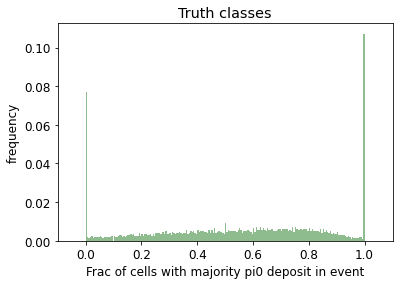

In [80]:
# PointNet (1 track) no cuts
model_file_path = "/fast_scratch_1/jbohm/cell_particle_deposit_learning/train_dirs/pnet_train_1/tr_124_val_33_tst_5_lr_1e-2_BS_100_no_tnets_1_track_add_min_dist"
epoch = 99 # start at 0

# PointNet++ (1 track) no cuts
#model_file_path = "/fast_scratch_1/jbohm/cell_particle_deposit_learning/train_dirs/pnet_train_1/pnet2_msg_tr_50_val_5_tst_5_lr_1e-2_BS_32_rad_0.2_0.2_0.1_0.05_nsamp_150_100_75_50"
#epoch = 13 # start at 0

# PointNet++ MSG (1 track) no cuts
#model_file_path = "/fast_scratch_1/jbohm/cell_particle_deposit_learning/train_dirs/pnet_train_1/tr_50_val_5_tst_5_lr_1e-2_BS_100_no_tnets_1_track_add_min_dist"
#epoch = 99 # start at 0

num_epochs = epoch + 1

labels_unmasked = np.load(model_file_path + "/tests/labels.npy")[:len(processed_event_data["class_frac_pi0_energy"])]
preds_unmasked = np.load(model_file_path + "/tests/preds_" + str(epoch) + ".npy")[:len(processed_event_data["class_frac_pi0_energy"])]

#labels_unmasked = np.load(model_file_path + "/tests/test_1_track_labels.npy")[:len(processed_event_data["class_frac_pi0_energy"])]
#preds_unmasked = np.load(model_file_path + "/tests/test_1_track_preds_" + str(epoch) + ".npy")[:len(processed_event_data["class_frac_pi0_energy"])]


preds = preds_unmasked[labels_unmasked != -1]
labels = labels_unmasked[labels_unmasked != -1]

clus_frac_em_class = np.array([np.sum(clus_labels[clus_labels != -1]) / len(clus_labels[clus_labels != -1]) for clus_labels in labels_unmasked])
pu.plot_hist(clus_frac_em_class, 200, "Truth classes", "Frac of cells with majority pi0 deposit in event", "frequency", True, "darkseagreen", (-0.1,1.1))


In [72]:
# TEST DATA LOAD - to see if it aligns with predictions loaded
print("num events (predictions)", preds_unmasked.shape[0])
print("num events (loaded data):", len(processed_event_data["x"]))
print("num events (loaded data):", len(processed_event_track_data["x"]))

num events (predictions) 19000
num events (loaded data): 19000
num events (loaded data): 19000


accuracy: 0.8727138876873021
3349737
3349737


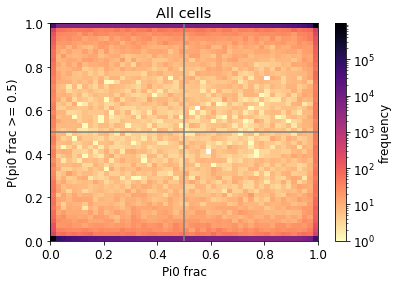

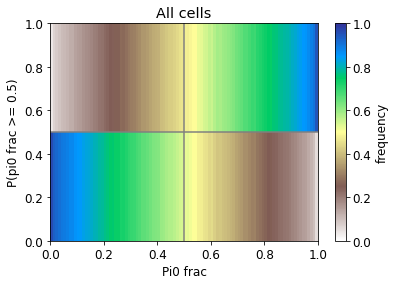

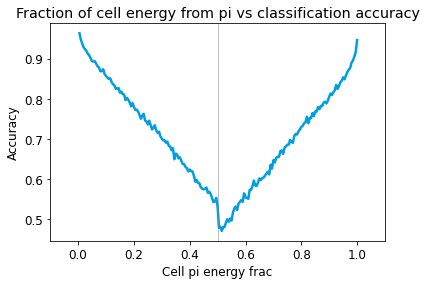

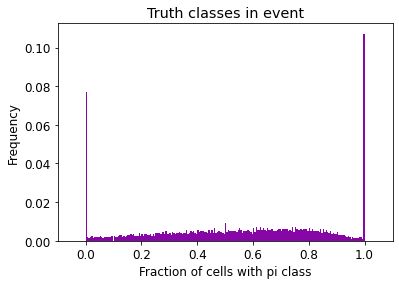

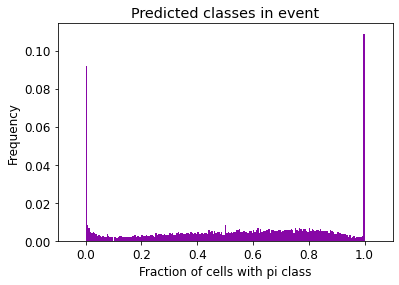

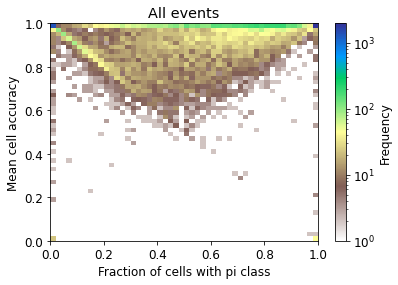

bottom_left: 0.001
top_left: 0.069
bottom_right: 0.002
top_right: 0.101
sum of event fracs: 0.999


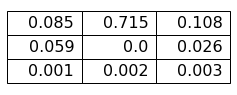


% events all low em class: 0.08479
% events all high em class: 0.10816
% events falsey all low em class: 0.01816
% events falsey all high em class: 0.00958


In [111]:
#train_summary_stats(model_file_path, num_epochs, False)
# plot train loss and accuracy summary over epoch
print("accuracy:", get_accuracy(preds, labels))
# plot 2d hist of em frac vs predicted probability of high em class
pi0_frac = np.array(flatten_one_layer(processed_event_data["frac_pi0_energy"]))

print(len(pi0_frac))
print(len(preds))
plot_pi0_frac_vs_preds(pi0_frac, preds)

# plot em frac vs preds plots
plot_pi0_frac_vs_preds_normalize_col(pi0_frac, preds, bins=(100,2))
# plot accuracy
plot_accuracy_over_pi0_cut(preds, labels, pi0_frac, 200)
# plot event frac of cells with em class plots
plot_clus_similarity_distribution(preds_unmasked, labels_unmasked, 50)
x_plot_idxs_dict = get_cross_plot_quadrent_info(preds_unmasked, labels_unmasked, processed_event_data["class_frac_pi0_energy"])


In [12]:
for event_idx in x_plot_idxs_dict["quad_2"]:
    plot_event_3d_info(event_idx, np.array(processed_event_data["frac_pi0_energy"][event_idx]), np.array(processed_event_data["class_frac_pi0_energy"][event_idx]), preds_unmasked[event_idx][labels_unmasked[event_idx] != -1])

NameError: name 'x_plot_idxs_dict' is not defined

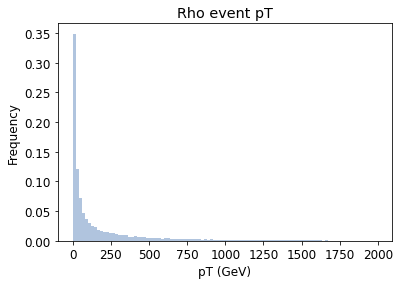

In [44]:
# split by event Pt
rho_event_pT = np.array(ak.Array(processed_event_data["truthPartPt"])[:, 0])
pu.plot_hist(rho_event_pT, 100, "Rho event pT", "pT (GeV)", "Frequency", colour="lightsteelblue")

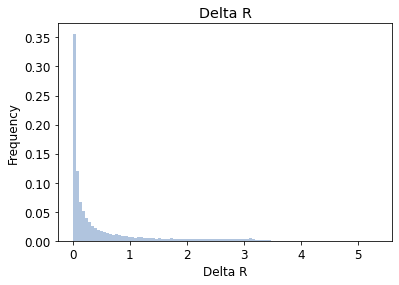

In [43]:

pipm_idx = 1
pi0_idx = 2

pipm_etas = np.array(ak.Array(processed_event_data['truthPartEta'])[:, pipm_idx])
pipm_phis = np.array(ak.Array(processed_event_data['truthPartPhi'])[:, pipm_idx])
pipm_pTs = np.array(ak.Array(processed_event_data['truthPartPt'])[:, pipm_idx])

pi0_etas = np.array(ak.Array(processed_event_data['truthPartEta'])[:, pi0_idx])
pi0_phis = np.array(ak.Array(processed_event_data['truthPartPhi'])[:, pi0_idx])
pi0_pTs = np.array(ak.Array(processed_event_data['truthPartPt'])[:, pi0_idx])

pipm_vectors = vector.obj(eta=pipm_etas, phi=pipm_phis, rho=pipm_pTs)
pi0_vectors = vector.obj(eta=pi0_etas, phi=pi0_phis, rho=pi0_pTs)

delta_R = pipm_vectors.deltaR(pi0_vectors)

pu.plot_hist(delta_R, 100, "Delta R", "Delta R", "Frequency", colour="lightsteelblue")


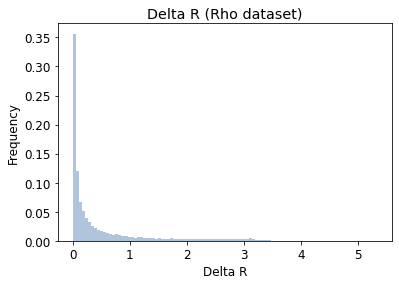

/tmp/ipykernel_15690/2564665237.py:30: RuntimeWarning: overflow encountered in sinh
  z = rhos * np.sinh(eta)


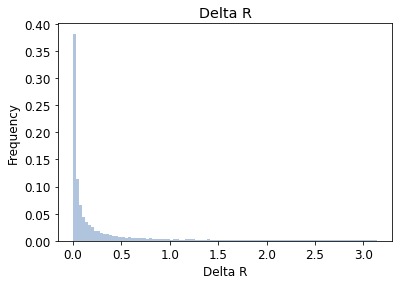

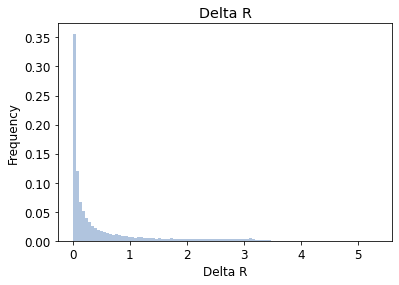

In [41]:
import vector

# A)
pipm_idx = 1
pi0_idx = 2

pipm_etas = np.array(ak.Array(processed_event_data['truthPartEta'])[:, pipm_idx])
pipm_phis = np.array(ak.Array(processed_event_data['truthPartPhi'])[:, pipm_idx])

pi0_etas = np.array(ak.Array(processed_event_data['truthPartEta'])[:, pi0_idx])
pi0_phis = np.array(ak.Array(processed_event_data['truthPartPhi'])[:, pi0_idx])

# angular separation between the vectors in the eta/phi plane - over events
delta_etas = pipm_etas - pi0_etas
delta_phis =  pipm_phis - pi0_phis
delta_phis = np.array([delta_phi - 2*math.pi if delta_phi > math.pi else (delta_phi + 2*math.pi if delta_phi < -math.pi else delta_phi) for delta_phi in delta_phis])
delta_R = np.sqrt((delta_etas)**2 + (delta_phis)**2)

pu.plot_hist(delta_R, 100, "Delta R (Rho dataset)", "Delta R", "Frequency", colour="lightsteelblue")


# don't use transverse momentum
def eta_phi_to_cartesian(etas, phis):    
    # Compute transverse component (rho) from eta.
    rhos = np.exp(-etas)
    
    # Compute Cartesian coordinates (x, y, z) from rho, phi, and eta.
    x = rhos * np.cos(phis)
    y = rhos * np.sin(phis)
    z = rhos * np.sinh(eta)
    
    return x, y, z


pipm_idx = 1
pi0_idx = 2

pipm_etas = np.array(ak.Array(processed_event_data['truthPartEta'])[:, pipm_idx])
pipm_phis = np.array(ak.Array(processed_event_data['truthPartPhi'])[:, pipm_idx])
pipm_pTs = np.array(ak.Array(processed_event_data['truthPartPt'])[:, pipm_idx])

pi0_etas = np.array(ak.Array(processed_event_data['truthPartEta'])[:, pi0_idx])
pi0_phis = np.array(ak.Array(processed_event_data['truthPartPhi'])[:, pi0_idx])
pi0_pTs = np.array(ak.Array(processed_event_data['truthPartPt'])[:, pi0_idx])

# B) Convert eta and phi to Cartesian coordinates (x, y, z).
x_pipm, y_pipm, z_pipm = eta_phi_to_cartesian(pipm_etas, pipm_phis)
x_pi0, y_pi0, z_pi0 = eta_phi_to_cartesian(pi0_etas, pi0_phis)

pipm_vectors = vector.obj(x=x_pipm, y=y_pipm, z=z_pipm)
pi0_vectors = vector.obj(x=x_pi0, y=y_pi0, z=z_pi0)


delta_R = pipm_vectors.deltaR(pi0_vectors)

pu.plot_hist(delta_R, 100, "Delta R", "Delta R", "Frequency", colour="lightsteelblue")

# C) just use eta & phi
pipm_vectors = vector.obj(eta=pipm_etas, phi=pipm_phis, rho=pipm_pTs)
pi0_vectors = vector.obj(eta=pi0_etas, phi=pi0_phis, rho=pi0_pTs)

delta_R = pipm_vectors.deltaR(pi0_vectors)

pu.plot_hist(delta_R, 100, "Delta R", "Delta R", "Frequency", colour="lightsteelblue")


frac of events in cut: 0.9853157894736843


/tmp/ipykernel_36882/1631229894.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  em_frac = np.array(flatten_one_layer(np.array(processed_event_data["frac_pi0_energy"])[cut]))


accuracy (from preds): 0.865904496478781


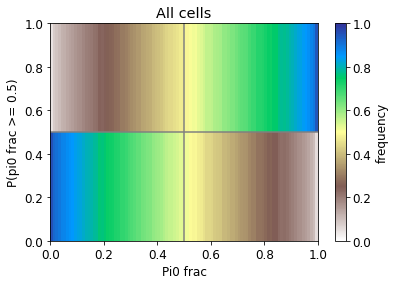

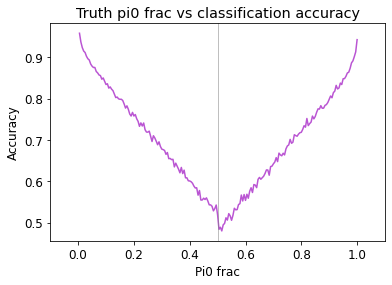

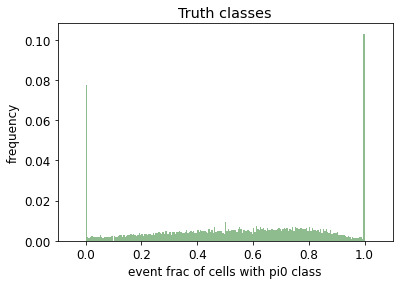

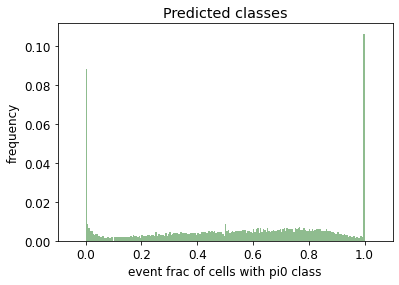

KeyboardInterrupt: 

In [521]:
# apply cut to events
cut = (track_pipm_delta_R < 0.1)
print("frac of events in cut:", np.count_nonzero(cut)/len(cut))
preds_unmasked_cut = preds_unmasked[cut]
labels_unmasked_cut = labels_unmasked[cut]
preds_cut = preds_unmasked_cut[labels_unmasked_cut != -1]
labels_cut = labels_unmasked_cut[labels_unmasked_cut != -1]

em_frac = np.array(flatten_one_layer(np.array(processed_event_data["frac_pi0_energy"])[cut]))
class_frac_pi0_energy = ak.Array(processed_event_data["class_frac_pi0_energy"])[cut]

# plot train loss and accuracy summary over epoch
print("accuracy (from preds):", get_accuracy(preds_cut, labels_cut))

# plot em frac vs preds plots
plot_pi0_frac_vs_preds_normalize_col(em_frac, preds_cut, bins=(100,2))
# plot accuracy
plot_accuracy_over_pi0_cut(preds_cut, labels_cut, em_frac, 200)
# plot event frac of cells with em class plots
plot_clus_similarity_distribution(preds_unmasked_cut, labels_unmasked_cut, 50)
x_plot_idxs_dict = get_cross_plot_quadrent_info(preds_unmasked_cut, labels_unmasked_cut, class_frac_pi0_energy)

KeyboardInterrupt: 

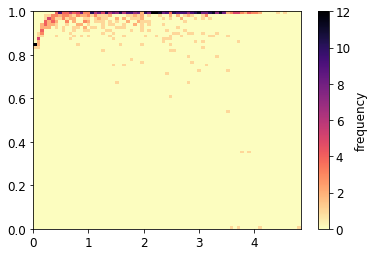

In [456]:
pointwise_delta_R = np.array(flatten_one_layer([np.tile(delta_R[event_idx], len(event_cell_data)) for event_idx, event_cell_data in enumerate(processed_event_data["cell_E"])]))
pointwise_pT = np.array(flatten_one_layer([np.tile(rho_event_pT[event_idx], len(event_cell_data)) for event_idx, event_cell_data in enumerate(processed_event_data["cell_E"])]))

delta_R_cut = 10
pT_cut = 30000

plot_accuracy_over_cut(preds[pointwise_delta_R < delta_R_cut], labels[pointwise_delta_R < delta_R_cut], pointwise_delta_R[pointwise_delta_R < delta_R_cut], 1000, "Delta R versus accuracy", "Delta R")
plot_accuracy_over_cut(preds[pointwise_pT < pT_cut], labels[pointwise_pT < pT_cut], pointwise_pT[pointwise_pT < pT_cut], 1000, "Rho event pT versus accuracy", "pT (GeV)")

print("frac events w delta R <", str(delta_R_cut) + ":" , np.count_nonzero([pointwise_delta_R < delta_R_cut])/len(pointwise_delta_R))
print("frac events w pT < ", str(pT_cut) + ":", np.count_nonzero([pointwise_pT < pT_cut])/len(pointwise_pT))

EVENT INDEX: 17
Accuracy (from preds): 0.8904109589041096
Accuracy (from em prob classified): 0.5821917808219178
delta R: 0.019794282518566853
pT: 229.25729370117188
num track points: 7


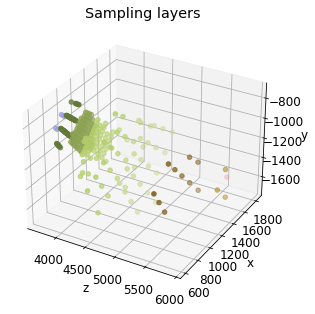

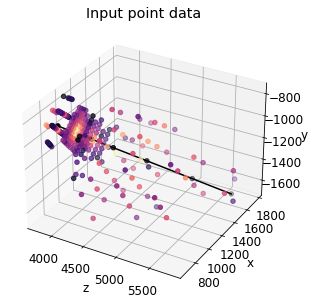

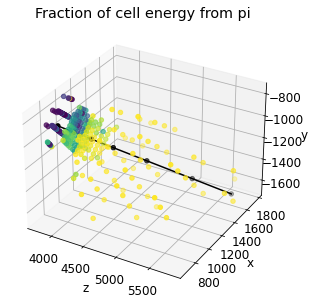

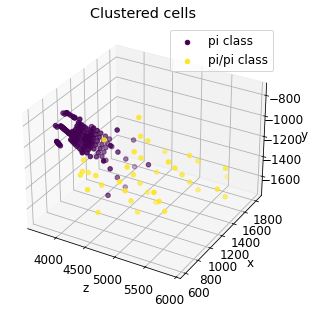

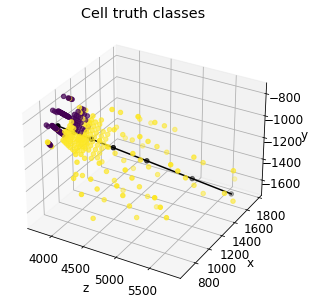

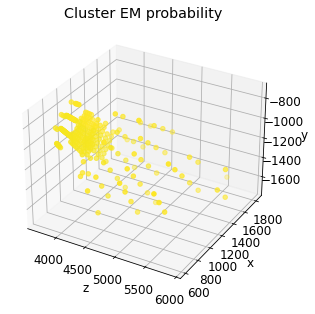

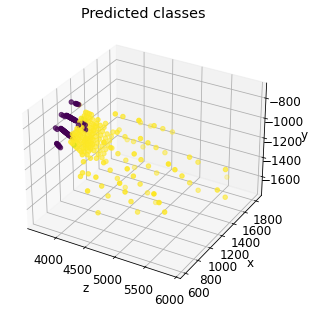

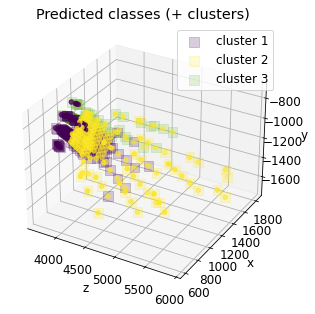

In [140]:
for event_idx in [17]:#x_plot_idxs_dict["quad_2"]:
    class_em_prob = [1 if cell_em_prob > 0.5 else 0 for cell_em_prob in processed_event_data["clus_em_prob"][event_idx]]
    print("EVENT INDEX:", event_idx)
    print("Accuracy (from preds):", get_accuracy(preds_unmasked[event_idx][labels_unmasked[event_idx] != -1], labels_unmasked[event_idx][labels_unmasked[event_idx] != -1]))
    print("Accuracy (from em prob classified):", get_accuracy(class_em_prob, labels_unmasked[event_idx][labels_unmasked[event_idx] != -1]))
    print("delta R:", delta_R[event_idx])
    print("pT:", rho_event_pT[event_idx])

    # track issues debug
    print("num track points:", np.count_nonzero(processed_event_track_data["x"][event_idx] != 0))


    plot_event_3d_info(event_idx, np.array(processed_event_data["frac_pi0_energy"][event_idx]), np.array(processed_event_data["class_frac_pi0_energy"][event_idx]), preds_unmasked[event_idx][labels_unmasked[event_idx] != -1])

In [ ]:
print(processed_event_data["clus_idx"][7])
print(processed_event_data["cell_E"][7])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.406, 0.325, 1.02, -0.132, -0.6, -1.22, ... -0.553, 0.0936, -0.794, -0.921, -0.457]


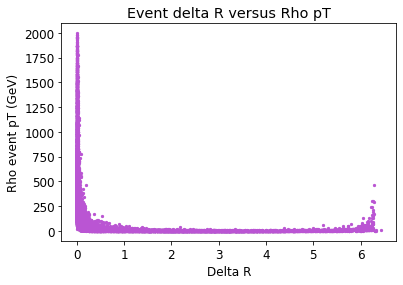

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.scatter(delta_R, rho_event_pT, color="mediumorchid", s=5)
plt.xlabel("Delta R")
plt.ylabel("Rho event pT (GeV)")
plt.title("Event delta R versus Rho pT")
plt.show()

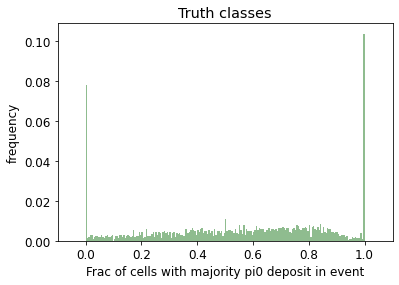

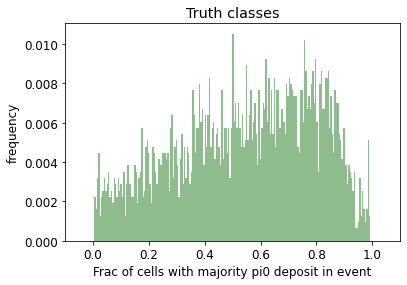

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3826 but corresponding boolean dimension is 19000

In [362]:
# cut data for training
clus_frac_em_class = np.array([np.sum(event_class_frac_pi0_energy) / len(event_class_frac_pi0_energy) for event_class_frac_pi0_energy in processed_event_data["class_frac_pi0_energy"]])
pu.plot_hist(clus_frac_em_class, 200, "Truth classes", "Frac of cells with majority pi0 deposit in event", "frequency", True, "darkseagreen", (-0.1,1.1))


# a) cut homogeneously classified events
cut = (clus_frac_em_class != 0) & (clus_frac_em_class != 1)
pu.plot_hist(clus_frac_em_class[cut], 200, "Truth classes", "Frac of cells with majority pi0 deposit in event", "frequency", True, "darkseagreen", (-0.1,1.1))


# b) cut out events with high delta R (large separation between pion showers)
pu.plot_hist(clus_frac_em_class[delta_R < 0.4], 200, "Truth classes", "Frac of cells with majority pi0 deposit in event", "frequency", True, "darkseagreen", (-0.1,1.1))



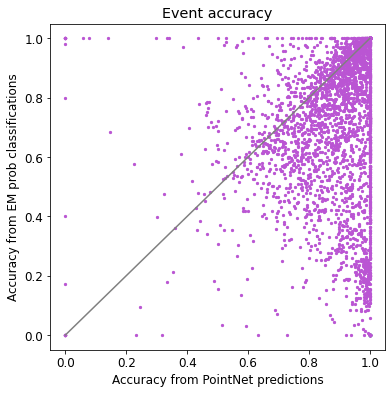

overall acc (from preds): 0.8714780536919738
overall acc (from em prob class): 0.7028217212901422


In [ ]:
event_acc_pointnet = [get_accuracy(preds_unmasked[event_idx][event_labels_unmasked != -1], event_labels_unmasked[event_labels_unmasked != -1]) for event_idx, event_labels_unmasked in enumerate(labels_unmasked)]
event_acc_em_prob = [get_accuracy([1 if cell_em_prob > 0.5 else 0 for cell_em_prob in event_em_prob], processed_event_data["class_frac_pi0_energy"][event_idx]) for event_idx, event_em_prob in enumerate(processed_event_data["clus_em_prob"])]
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')
plt.scatter(event_acc_pointnet, event_acc_em_prob, color="mediumorchid", s=5)
plt.plot([0, 1], [0, 1], color="grey")
plt.xlabel("Accuracy from PointNet predictions")
plt.ylabel("Accuracy from EM prob classifications")
plt.title("Event accuracy")
plt.show()

print("overall acc (from preds):", get_accuracy(preds, labels))
print("overall acc (from em prob class):", get_accuracy(np.array([1 if cell_em_prob > 0.5 else 0 for cell_em_prob in flatten_one_layer(processed_event_data["clus_em_prob"])]), labels))


Analyze particle segmentation splitting topoclusters

frac of topoclusters with split labels: 0.2775


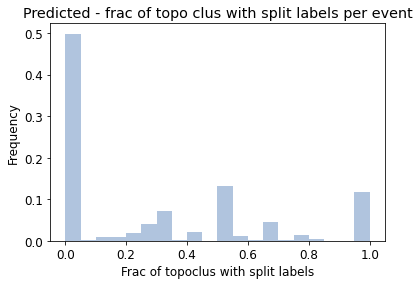

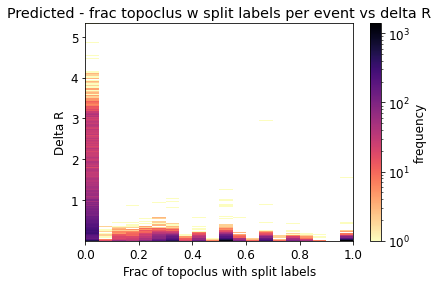

frac of topoclusters with split labels: 0.2355


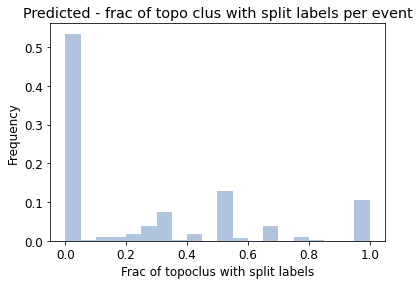

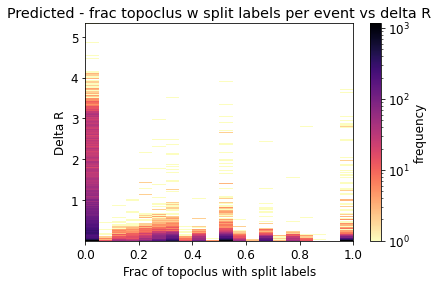

accuracy of clus split: 0.8457


In [345]:
def get_topoclus_split_analysis_binary(labels, delta_R, split_range=0):
    clus_split = []
    
    for event_idx, event_clus_idxs in enumerate(processed_event_data["clus_idx"]):
        clus_split.append([])
        for clus_idx in range(np.max(event_clus_idxs) + 1):
            cut_clus_idx = np.array(event_clus_idxs) == clus_idx
            is_cell_pi0_labeled = labels[event_idx][cut_clus_idx] == 1 
            num_cells_pi0_labeled = np.count_nonzero(is_cell_pi0_labeled)
            if len(is_cell_pi0_labeled): # some clus empty??
                frac_cells_pi0_labeled = num_cells_pi0_labeled / len(is_cell_pi0_labeled)
                is_clus_labels_split =  split_range < frac_cells_pi0_labeled and frac_cells_pi0_labeled < 1 - split_range
                clus_split[event_idx].append(is_clus_labels_split)

    # fraction of topoclusters getting split
    frac_topoclus_split = np.count_nonzero(flatten_one_layer(clus_split)) / len(flatten_one_layer(clus_split))
    print("frac of topoclusters with split labels:", round(frac_topoclus_split, 4))
    
    # plot 1D distribution of the frac of topoclusters getting split / event
    event_frac_clus_split = np.array([np.count_nonzero(event_clus_split)/len(event_clus_split) for event_clus_split in clus_split])
    pu.plot_hist(event_frac_clus_split, 20, "Predicted - frac of topo clus with split labels per event", "Frac of topoclus with split labels", "Frequency", colour="lightsteelblue")

    # plot 2D distribution of event delta R vs frac of topoclusters getting split / event
    delta_R_cut = 100
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(event_frac_clus_split[delta_R < delta_R_cut], delta_R[delta_R < delta_R_cut], (20, 200), cmap=plt.cm.magma_r, norm=mpl.colors.LogNorm())
    plt.colorbar(label="frequency")
    plt.xlabel("Frac of topoclus with split labels")
    plt.ylabel("Delta R")
    plt.title("Predicted - frac topoclus w split labels per event vs delta R")
    plt.show()

    return np.array(flatten_one_layer(clus_split))

split_range = 0.1
# get totpocluster analysis for truth labels
truth_clus_split = get_topoclus_split_analysis_binary(processed_event_data["class_frac_pi0_energy"], delta_R, split_range)

# get totpocluster analysis for predicted labels
predicted_labels = [event_preds_unmasked[labels_unmasked[event_idx] != -1] for event_idx, event_preds_unmasked in enumerate(preds_unmasked)]
pred_clus_split = get_topoclus_split_analysis_binary(predicted_labels, delta_R, split_range)

print("accuracy of clus split:", round(np.count_nonzero(truth_clus_split == pred_clus_split) / len(truth_clus_split), 4))


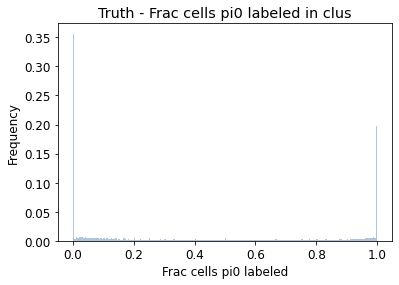

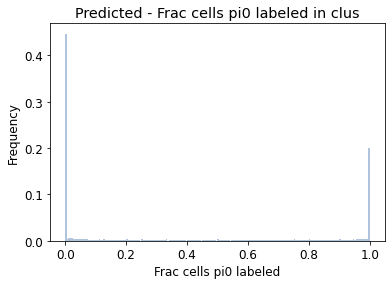

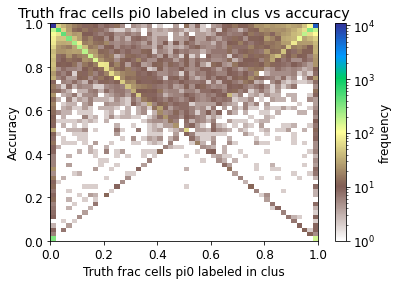

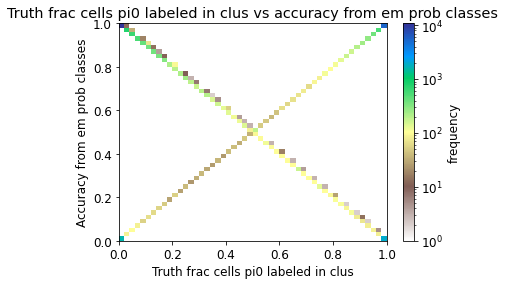

In [245]:
def get_frac_cells_pi0_labeled(labels):
        frac_cells_pi0_labeled = []
        for event_idx, event_clus_idxs in enumerate(processed_event_data["clus_idx"]):
            for clus_idx in range(np.max(event_clus_idxs) + 1):
                cut_clus_idx = np.array(event_clus_idxs) == clus_idx
                is_cell_pi0_labeled = labels[event_idx][cut_clus_idx] == 1 
                num_cells_pi0_labeled = np.count_nonzero(is_cell_pi0_labeled)
                if np.count_nonzero(cut_clus_idx): # some clus empty??
                    frac_cells_pi0_labeled_clus = num_cells_pi0_labeled / len(is_cell_pi0_labeled)
                    frac_cells_pi0_labeled.append(frac_cells_pi0_labeled_clus)
        return frac_cells_pi0_labeled

def get_topoclus_split_analysis_continuous(labels_unmasked, preds_unmasked, delta_R, delta_R_cut=100):
    truth_frac_cells_pi0_labeled = get_frac_cells_pi0_labeled(processed_event_data["class_frac_pi0_energy"])
    preds = [event_preds_unmasked[labels_unmasked[event_idx] != -1] for event_idx, event_preds_unmasked in enumerate(preds_unmasked)]
    pred_frac_cells_pi0_labeled = get_frac_cells_pi0_labeled(preds)

    labels = [event_labels_unmasked[event_labels_unmasked != -1] for event_labels_unmasked in labels_unmasked]
    clus_accuracy = []
    clus_accuracy_em_prob = []
    clus_delta_R = []
    for event_idx, event_clus_idxs in enumerate(processed_event_data["clus_idx"]):
            for clus_idx in range(np.max(event_clus_idxs) + 1):
                cut_clus_idx = np.array(event_clus_idxs) == clus_idx
                if np.count_nonzero(cut_clus_idx):
                    clus_accuracy.append(get_accuracy(labels[event_idx][cut_clus_idx], preds[event_idx][cut_clus_idx]))
                    clus_accuracy_em_prob.append(get_accuracy(labels[event_idx][cut_clus_idx], [1 if cell_em_prob > 0.5 else 0 for cell_em_prob in processed_event_data["clus_em_prob"][event_idx][cut_clus_idx]]))
                    clus_delta_R.append(delta_R[event_idx])

    truth_frac_cells_pi0_labeled = np.array(truth_frac_cells_pi0_labeled)
    pred_frac_cells_pi0_labeled = np.array(pred_frac_cells_pi0_labeled)
    clus_accuracy = np.array(clus_accuracy)
    clus_accuracy_em_prob = np.array(clus_accuracy_em_prob)
    clus_delta_R = np.array(clus_delta_R)

    # plot truth distribution of frac cells pi0 labeled in clus
    pu.plot_hist(truth_frac_cells_pi0_labeled[clus_delta_R < delta_R_cut], 200, "Truth - Frac cells pi0 labeled in clus", "Frac cells pi0 labeled", "Frequency", colour="lightsteelblue")
    pu.plot_hist(pred_frac_cells_pi0_labeled[clus_delta_R < delta_R_cut], 200, "Predicted - Frac cells pi0 labeled in clus", "Frac cells pi0 labeled", "Frequency", colour="lightsteelblue")
    
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(truth_frac_cells_pi0_labeled[clus_delta_R < delta_R_cut], clus_accuracy[clus_delta_R < delta_R_cut], (50, 50), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
    plt.colorbar(label="frequency")
    plt.xlabel("Truth frac cells pi0 labeled in clus")
    plt.ylabel("Accuracy")
    plt.title("Truth frac cells pi0 labeled in clus vs accuracy")
    plt.show()


    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(truth_frac_cells_pi0_labeled[clus_delta_R < delta_R_cut], clus_accuracy_em_prob[clus_delta_R < delta_R_cut], (50, 50), cmap=plt.cm.terrain_r, norm=mpl.colors.LogNorm())
    plt.colorbar(label="frequency")
    plt.xlabel("Truth frac cells pi0 labeled in clus")
    plt.ylabel("Accuracy from em prob classes")
    plt.title("Truth frac cells pi0 labeled in clus vs accuracy from em prob classes")
    plt.show()

#get_topoclus_split_analysis_continuous(labels_unmasked, preds_unmasked, delta_R, 0.01)

clus_acc_em_prob = [get_accuracy([1 if cell_em_prob > 0.5 else 0 for cell_em_prob in event_em_prob], processed_event_data["class_frac_pi0_energy"][event_idx]) for event_idx, event_em_prob in enumerate(processed_event_data["clus_em_prob"])]

get_topoclus_split_analysis_continuous(labels_unmasked, preds_unmasked, delta_R)




Track distance from particles analysis

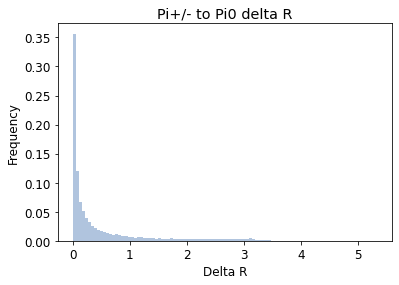

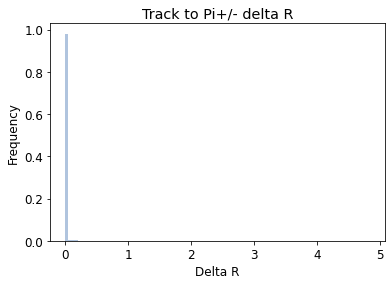

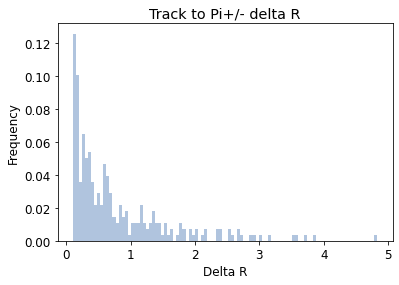

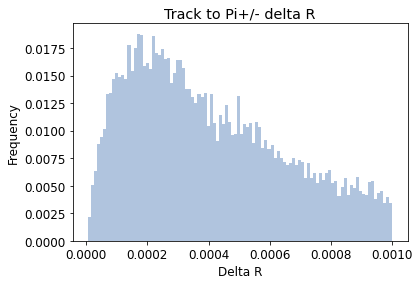

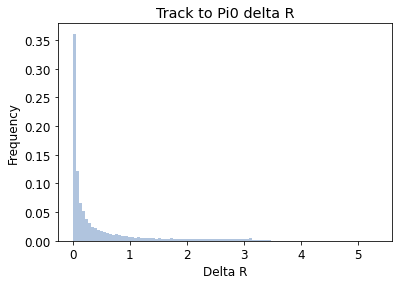

frac events with delta pi+/- to track distance > 0.1: 0.01468421052631579
frac events with delta pi+/- to track distance > 0.01: 0.03205263157894737
frac events with delta pi+/- to track distance > 0.001: 0.30294736842105263


In [477]:
pipm_idx = 1
pi0_idx = 2

pipm_etas = np.array(ak.Array(processed_event_data['truthPartEta'])[:, pipm_idx])
pipm_phis = np.array(ak.Array(processed_event_data['truthPartPhi'])[:, pipm_idx])
pipm_pTs = np.array(ak.Array(processed_event_data['truthPartPt'])[:, pipm_idx])

pi0_etas = np.array(ak.Array(processed_event_data['truthPartEta'])[:, pi0_idx])
pi0_phis = np.array(ak.Array(processed_event_data['truthPartPhi'])[:, pi0_idx])
pi0_pTs = np.array(ak.Array(processed_event_data['truthPartPt'])[:, pi0_idx])

track_etas = np.squeeze(np.array(processed_event_track_data['track_eta']))
track_phis = np.squeeze(np.array(processed_event_track_data['track_phi']))
track_pTs = np.squeeze(np.array(processed_event_track_data['P']))


# angular separation between the vectors in the eta/phi plane - over events
pipm_vectors = vector.obj(eta=pipm_etas, phi=pipm_phis, rho=pipm_pTs)
pi0_vectors = vector.obj(eta=pi0_etas, phi=pi0_phis, rho=pi0_pTs)
track_vectors = vector.obj(eta=track_etas, phi=track_phis, rho=track_pTs)
track_pipm_delta_R = pipm_vectors.deltaR(track_vectors)
track_pi0_delta_R = pi0_vectors.deltaR(track_vectors)
pipm_pi0_delta_R = pi0_vectors.deltaR(pipm_vectors)

pu.plot_hist(pipm_pi0_delta_R, 100, "Pi+/- to Pi0 delta R", "Delta R", "Frequency", colour="lightsteelblue")
pu.plot_hist(track_pipm_delta_R, 100, "Track to Pi+/- delta R", "Delta R", "Frequency", colour="lightsteelblue")

pu.plot_hist(track_pipm_delta_R[track_pipm_delta_R > 0.1], 100, "Track to Pi+/- delta R", "Delta R", "Frequency", colour="lightsteelblue")
pu.plot_hist(track_pipm_delta_R[track_pipm_delta_R < 0.001], 100, "Track to Pi+/- delta R", "Delta R", "Frequency", colour="lightsteelblue")
pu.plot_hist(track_pi0_delta_R, 100, "Track to Pi0 delta R", "Delta R", "Frequency", colour="lightsteelblue")

print("frac events with delta pi+/- to track distance > 0.1:", np.count_nonzero(track_pipm_delta_R[track_pipm_delta_R > 0.1])/len(track_pipm_delta_R))
print("frac events with delta pi+/- to track distance > 0.01:", np.count_nonzero(track_pipm_delta_R[track_pipm_delta_R > 0.01])/len(track_pipm_delta_R))
print("frac events with delta pi+/- to track distance > 0.001:", np.count_nonzero(track_pipm_delta_R[track_pipm_delta_R > 0.001])/len(track_pipm_delta_R))


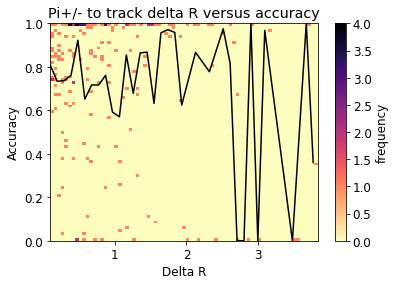

KeyboardInterrupt: 

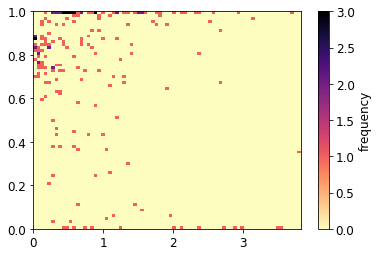

In [476]:
pointwise_delta_R = np.array(flatten_one_layer([np.tile(delta_R[event_idx], len(event_cell_data)) for event_idx, event_cell_data in enumerate(processed_event_data["cell_E"])]))
pointwise_track_pipm_delta_R = np.array(flatten_one_layer([np.tile(track_pipm_delta_R[event_idx], len(event_cell_data)) for event_idx, event_cell_data in enumerate(processed_event_data["cell_E"])]))
pointwise_track_pi0_delta_R = np.array(flatten_one_layer([np.tile(track_pi0_delta_R[event_idx], len(event_cell_data)) for event_idx, event_cell_data in enumerate(processed_event_data["cell_E"])]))


delta_R_cut = 0.1
plot_accuracy_over_cut(preds[pointwise_track_pipm_delta_R > delta_R_cut], labels[pointwise_track_pipm_delta_R > delta_R_cut], pointwise_track_pipm_delta_R[pointwise_track_pipm_delta_R > delta_R_cut], 1000, "Pi+/- to track delta R versus accuracy", "Delta R")


delta_R_cut = 10
plot_accuracy_over_cut(preds[pointwise_track_pipm_delta_R < delta_R_cut], labels[pointwise_track_pipm_delta_R < delta_R_cut], pointwise_track_pipm_delta_R[pointwise_track_pipm_delta_R < delta_R_cut], 1000, "Pi+/- to track delta R versus accuracy", "Delta R")


delta_R_cut = 0.1
plot_accuracy_over_cut(preds[pointwise_track_pipm_delta_R < delta_R_cut], labels[pointwise_track_pipm_delta_R < delta_R_cut], pointwise_track_pipm_delta_R[pointwise_track_pipm_delta_R < delta_R_cut], 1000, "Pi+/- to track delta R versus accuracy", "Delta R")

delta_R_cut = 0.01
plot_accuracy_over_cut(preds[pointwise_track_pipm_delta_R < delta_R_cut], labels[pointwise_track_pipm_delta_R < delta_R_cut], pointwise_track_pipm_delta_R[pointwise_track_pipm_delta_R < delta_R_cut], 1000, "Pi+/- to track delta R versus accuracy", "Delta R")


delta_R_cut = 0.001
plot_accuracy_over_cut(preds[pointwise_track_pipm_delta_R < delta_R_cut], labels[pointwise_track_pipm_delta_R < delta_R_cut], pointwise_track_pipm_delta_R[pointwise_track_pipm_delta_R < delta_R_cut], 1000, "Pi+/- to track delta R versus accuracy", "Delta R")



#plot_accuracy_over_cut(preds[pointwise_track_pi0_delta_R < delta_R_cut], labels[pointwise_track_pi0_delta_R < delta_R_cut], pointwise_track_pi0_delta_R[pointwise_track_pi0_delta_R < delta_R_cut], 1000, "Pi0 to track delta R versus accuracy", "Delta R")


Plot detector geometry

In [311]:
file = ur.open("/data/atlas/data/rho_delta/rho_small.root")

events = file["EventTree"]
cell_geo_tree = file["CellGeo"]

events_arr = events.arrays(library="ak")
cell_geo_tree_arr = cell_geo_tree.arrays(library="np")

In [312]:
from  util import graph_util as gu

# load cell geo tree dict (takes ~6 min)
cell_dict = gu.loadGraphDictionary(cell_geo_tree)

In [320]:
# by generic definition of spherical to cartesian coord conversion
def spherical_to_cartesian_cor(rs, phis, thetas):
    # convert to x, y, z
    x, y, z = [], [], []

    for i, r in enumerate(rs):
        x.append(r*np.cos(phis[i]))
        y.append(r*np.sin(phis[i]))
        z.append( r/np.tan(thetas[i]))

    return x,y,z

def plot_cells(cell_ids, cell_dict, cell_data, title, xlabel, ylabel, zlabel, colour_theme, bar_label, vmin=None, vmax=None, filter=None):
    phis = gu.convertIDToGeo(cell_ids, "cell_geo_phi", cell_dict)
    etas = gu.convertIDToGeo(cell_ids, "cell_geo_eta", cell_dict)
    rs = gu.convertIDToGeo(cell_ids, "cell_geo_rPerp", cell_dict)

    thetas = [2*np.arctan(np.exp(-eta)) for eta in etas]
    x, y, z = spherical_to_cartesian_cor(rs, phis, thetas)

    fig = plt.figure(figsize=(10, 8))
    fig.patch.set_facecolor('white')
    ax = fig.gca(projection='3d')

    
    # temp zoom to check for photons

    if filter == 'cut_half':
        filter_x, filter_y, filter_z, filter_energy = [], [], [], []
        for i, x_i in enumerate(x):
            if x_i < 0:
                continue
            #if x[i] > 2000:
            #    continue
            filter_x.append(x[i])
            filter_y.append(y[i])
            filter_z.append(z[i])
            filter_energy.append(cell_data[i])
    elif filter == 'cut_drop_tracks':
        filter_x, filter_y, filter_z, filter_energy = [], [], [], []
        for i, eta_i in enumerate(etas):
            if np.abs(eta_i) >= 4.9 or np.abs(phis[i]) > np.pi:
                continue
            #if x[i] > 2000:
            #    continue
            filter_x.append(x[i])
            filter_y.append(y[i])
            filter_z.append(z[i])
            filter_energy.append(cell_data[i])
    elif filter == 'cut_neg_eta':
        filter_x, filter_y, filter_z, filter_energy = [], [], [], []
        for i, eta_i in enumerate(etas):
            if eta_i > 0:
                continue
            filter_x.append(x[i])
            filter_y.append(y[i])
            filter_z.append(z[i])
            filter_energy.append(cell_data[i])
    elif filter == 'cut_neg_phi':
        filter_x, filter_y, filter_z, filter_energy = [], [], [], []
        for i, phi_i in enumerate(phis):
            if phi_i > 0:
                continue
            filter_x.append(x[i])
            filter_y.append(y[i])
            filter_z.append(z[i])
            filter_energy.append(cell_data[i])
    elif filter == 'cut_phi_0_half_pi':
        filter_x, filter_y, filter_z, filter_energy = [], [], [], []
        for i, phi_i in enumerate(phis):
            if phi_i > 0 and phi_i < np.pi/2:
                filter_x.append(x[i])
                filter_y.append(y[i])
                filter_z.append(z[i])
                filter_energy.append(cell_data[i])
            else:
                continue
    elif filter == 'cut_phi_0_neg_half_pi':
        filter_x, filter_y, filter_z, filter_energy = [], [], [], []
        for i, phi_i in enumerate(phis):
            if phi_i < 0 and phi_i > -np.pi/2:
                filter_x.append(x[i])
                filter_y.append(y[i])
                filter_z.append(z[i])
                filter_energy.append(cell_data[i])
            else:
                continue
            
    else:
        filter_x, filter_y, filter_z, filter_energy = [], [], [], []
        for i, x_i in enumerate(x):
            filter_x.append(x[i])
            filter_y.append(y[i])
            filter_z.append(z[i])
            filter_energy.append(cell_data[i])

    p = ax.scatter(filter_z, filter_x, filter_y, c=filter_energy, vmin=vmin, vmax=vmax, cmap=colour_theme)
    #p = ax.scatter(filter_z, filter_x, filter_y, c=filter_energy, cmap=colour_theme)
    fig.colorbar(p, label=bar_label, fraction=0.025)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.title(title)
    plt.show()

/tmp/ipykernel_36882/615769908.py:23: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


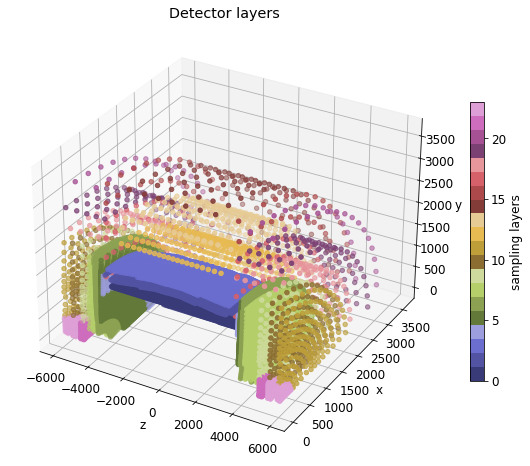

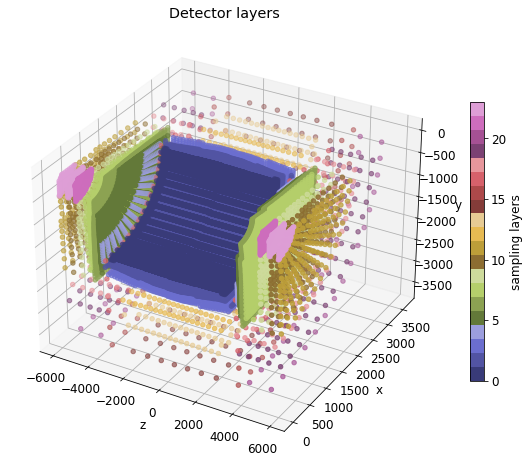

In [321]:
plot_cells(cell_ids, cell_dict, sampling_layers, "Detector layers", "z", "x", "y", plt.cm.tab20b, "sampling layers", filter="cut_phi_0_half_pi")
plot_cells(cell_ids, cell_dict, sampling_layers, "Detector layers", "z", "x", "y", plt.cm.tab20b, "sampling layers", filter="cut_phi_0_neg_half_pi")

In [372]:
arrs = ur.open("/fast_scratch_1/atlas_images/MLTree/rho_full_500.root:EventTree").arrays(library="np")
print(arrs["eventNumber"])

[  2001   2006   2009   2010   2012   2002   2013   2005   2004   2003
   2017   2016   2008   2011   2018   2022   2020   2023   2015   2024
   2014   2029   2019   2007   2031 560001 560005 560055 560063 560003
 560074 560036 560006 560053 560014 560075 560072 560073 560068 560071
 560069 560032 560065 560067 560082 560034 560076 560080 560084 560060
 802001 802056 802066 802063 802070 802068 802031 802054 802044 802064
 802002 802019 802074 802026 802078 802014 802023 802080 802012 802082
 802065 802079 802006 802084 802028 427585 427597 427584 427595 427589
 427581 427583 427588 427592 427598 427599 427604 427605 427586 427593
 427608 427613 427610 427601 427587 427615 427618 427617 427594 427616
 472001 472004 472002 472014 472005 472007 472009 472013 472003 472016
 472011 472019 472012 472020 472018 472015 472008 472010 472017 472027
 472028 472024 472023 472029 472032 213581 213582 213590 213584 213587
 213588 213589 213583 213585 213592 213591 213593 213596 213598 213586
 21360

0.8705531210360694


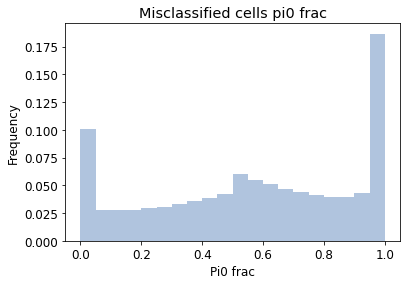

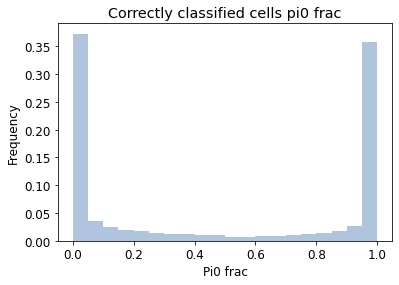

frac misclassified events with 45-55% pi0 deposit: 0.1014522166078969
frac misclassified events with 40-60% pi0 deposit: 0.19479812643993608
frac misclassified events with 30-70% pi0 deposit: 0.3617165537011114
frac misclassified events with 20-80% pi0 deposit: 0.5065000357461608


In [474]:
# look into what fraction of misclassified cells have their truth frac in different ranges
pred_class = preds > 0.5
pi0_frac = np.array(flatten_one_layer(processed_event_data["frac_pi0_energy"]))

cut_misclassified = (pred_class == labels)

print(np.count_nonzero(cut_misclassified)/len(cut_misclassified))

pu.plot_hist(pi0_frac[~cut_misclassified], 20, "Misclassified cells pi0 frac", "Pi0 frac", "Frequency", colour="lightsteelblue")
pu.plot_hist(pi0_frac[cut_misclassified], 20, "Correctly classified cells pi0 frac", "Pi0 frac", "Frequency", colour="lightsteelblue")

print("frac misclassified events with 45-55% pi0 deposit:", np.count_nonzero((0.45 < pi0_frac[~cut_misclassified]) & (pi0_frac[~cut_misclassified] < 0.55))/len(pi0_frac[~cut_misclassified]))
print("frac misclassified events with 40-60% pi0 deposit:", np.count_nonzero((0.40 < pi0_frac[~cut_misclassified]) & (pi0_frac[~cut_misclassified] < 0.60))/len(pi0_frac[~cut_misclassified]))
print("frac misclassified events with 30-70% pi0 deposit:", np.count_nonzero((0.30 < pi0_frac[~cut_misclassified]) & (pi0_frac[~cut_misclassified] < 0.70))/len(pi0_frac[~cut_misclassified]))
print("frac misclassified events with 20-80% pi0 deposit:", np.count_nonzero((0.20 < pi0_frac[~cut_misclassified]) & (pi0_frac[~cut_misclassified] < 0.80))/len(pi0_frac[~cut_misclassified]))


In [487]:
def plot_overlay_hist(data, bins, title, x_label, y_label, labels, colours=None, xlim=None, legend_loc=None):
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    if xlim == None:
        xlim = (ak.min(data, axis=None), ak.max(data, axis=None))
    for i, data in enumerate(data):
        counts, bins = np.histogram(data, bins, xlim)
        # normalize counts
        counts = counts / np.sum(counts)
        plt.stairs(counts, bins, label=labels[i], color=(colours[i] if colours != None else None))
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc=legend_loc)
    plt.xlim()
    plt.show()

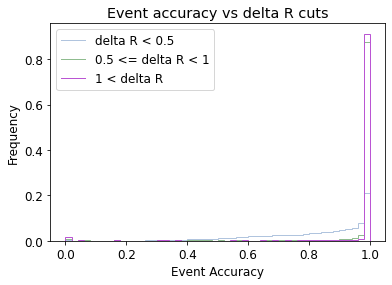

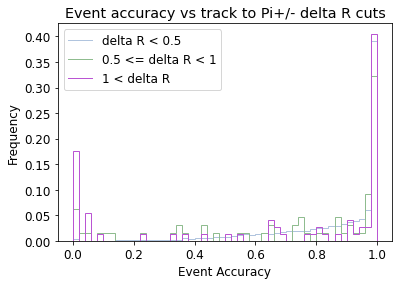

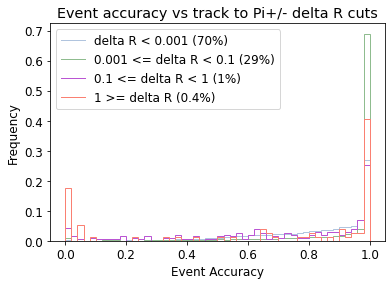

0.6970526315789474
0.28826315789473683
0.010789473684210526
0.0038947368421052633


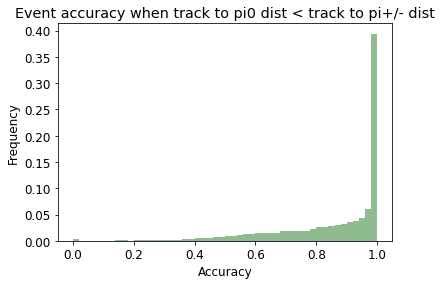

In [510]:
event_accuracy = np.array([np.count_nonzero(np.array(preds_unmasked[event_idx][event_labels_unmasked != -1]) == np.array(event_labels_unmasked[event_labels_unmasked != -1]))/len(event_labels_unmasked[event_labels_unmasked != -1]) for event_idx, event_labels_unmasked in enumerate(labels_unmasked)])

plot_overlay_hist([(event_accuracy[delta_R < 0.5]), event_accuracy[(0.5 <= delta_R) & (delta_R < 1)], event_accuracy[1 <= delta_R]], 50, "Event accuracy vs delta R cuts", "Event Accuracy", "Frequency", labels=["delta R < 0.5", "0.5 <= delta R < 1", "1 < delta R"], colours=["lightsteelblue", "darkseagreen", "mediumorchid"], legend_loc="upper left")
plot_overlay_hist([(event_accuracy[track_pipm_delta_R < 0.5]), event_accuracy[(0.5 <= track_pipm_delta_R) & (track_pipm_delta_R < 1)], event_accuracy[1 <= track_pipm_delta_R]], 50, "Event accuracy vs track to Pi+/- delta R cuts", "Event Accuracy", "Frequency", labels=["delta R < 0.5", "0.5 <= delta R < 1", "1 < delta R"], colours=["lightsteelblue", "darkseagreen", "mediumorchid"], legend_loc="upper left")
plot_overlay_hist([(event_accuracy[track_pipm_delta_R < 0.001]), event_accuracy[(0.001 <= track_pipm_delta_R) & (track_pipm_delta_R < 0.1)], event_accuracy[(0.1 <= track_pipm_delta_R) & (track_pipm_delta_R < 1)], event_accuracy[1 <= track_pipm_delta_R]], 50, "Event accuracy vs track to Pi+/- delta R cuts", "Event Accuracy", "Frequency", labels=["delta R < 0.001 (70%)", "0.001 <= delta R < 0.1 (29%)", "0.1 <= delta R < 1 (1%)","1 >= delta R (0.4%)"], colours=["lightsteelblue", "darkseagreen", "mediumorchid", "salmon"], legend_loc="upper left")

for cut in [(event_accuracy[track_pipm_delta_R < 0.001]), event_accuracy[(0.001 <= track_pipm_delta_R) & (track_pipm_delta_R < 0.1)], event_accuracy[(0.1 <= track_pipm_delta_R) & (track_pipm_delta_R < 1)], event_accuracy[1 <= track_pipm_delta_R]]:
    print(len(cut)/len(event_accuracy))


pu.plot_hist(event_accuracy[track_pipm_delta_R < track_pi0_delta_R], 50, "Event accuracy when track to pi0 dist < track to pi+/- dist", "Accuracy", "Frequency", colour="darkseagreen")

In [63]:
for i in range(100, 110):
    track_pipm_delta_R = np.load("/fast_scratch_1/jbohm/cell_particle_deposit_learning/rho_processed_train_files/delta_R/rho_full_len_6000_i_" + str(i) + "_track_pi0_delta_R.npy", allow_pickle=True)
    print("num track delta Rs", len(track_pipm_delta_R))
    point_net_data = np.load('/fast_scratch_1/jbohm/cell_particle_deposit_learning/train_dirs/pnet_train_1/train_1_track/rho_full_len_6000_i_' + str(i) + '_1_track.npz')
    cluster_data = point_net_data['X']
    print("num events", len(cluster_data))



num track delta Rs 3925
num events 3925
num track delta Rs 3856
num events 3856
num track delta Rs 3923
num events 3923
num track delta Rs 3862
num events 3862
num track delta Rs 3887
num events 3887
num track delta Rs 3958
num events 3958
num track delta Rs 3879
num events 3879
num track delta Rs 3856
num events 3856
num track delta Rs 3771
num events 3771
num track delta Rs 3859
num events 3859
